##Project : Fake Job Post Detection

In today's digital job market,the proliferation of fake job postings presents a challenge, undermining trust and efficiency in the job market. These ads waste people's time and can be hard to catch. To confront this issue, our team leverages the capabilities of different machine learning algorithms to find patterns in online job ads.
For our analysis we used a dataset from Kaggle, which is composed of 18 attributes, ranging from job titles and descriptions to company profiles and benefits. Beyond surface-level indicators, we tried to catch subtle nuances such as language tone, formatting irregularities, and discrepancies in contact information.
Our goal is to distinguish the fake job posts from the real ones so that we can prevent any issues caused by them, such as wasting time or falling victim to scams.


dataset link: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

slides link: https://gamma.app/docs/Introduction-to-NLP-Project-on-detecting-fraudulent-job-listings-46rsaw6pejinnfa?mode=doc

<span style="color:magenta">Group Names:</span>

* Margareta Anna Kulcsar
* Nayoung Kwon
* Ita Zaporozhets

# 0.0 Set up

## 0.1 Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import nltk
import re

import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import numpy as np
from torch.utils.data import Dataset
from transformers import AdamW, get_scheduler, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support


nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 0.2 Get Data

In [ ]:
df = pd.read_csv('fake_job_postings.csv')

# List of columns containing long (sentence strucutre, etc) text data
text_columns = ['description', 'company_profile', 'requirements', 'benefits']

# The target variable indicating whether a job posting is fraudulent or not
target_column = 'fraudulent'

The dataset is consisted of 17880 rows of tabular data with 18 features.

* job_id : unique key of each data point.
* title : The title of the job ad entry.
* location : Geographical location of the job ad.
* department : Corporate department (e.g. sales).
* salary_range : Indicative salary range (e.g. $50,000-$60,000)
* company_profile : A brief company description.
* description : The details description of the job ad.
* requirements : Enlisted requirements for the job opening.
* benefits : Enlisted offered benefits by the employer.
* telecommuting : True for telecommuting positions.
* has_company_logo : True if company logo is present.
* has_questions : True if screening questions are present.
* employment_type : Type of the employment. for example, Full-type, Part-time, Contract, etc.
* required_experience : required experience to apply. For example, Executive, Entry level, Intern, etc.
* required_education : required education level to apply. For example, Doctorate, Master’s Degree, Bachelor, etc.
* industry : The industry in which the company's in. For example, Automotive, IT, Health care, Real estate, etc.
* function : The position of the job. Consulting, Engineering, Research, Sales etc.
* fraudulent : target - Classification attribute.

# 1.0 Data Analysis

## 1.1 Sample Data Points

### 1.1.1 Description Comparison

#### **Fraudulant**

In [ ]:
pd.set_option('display.max_colwidth', None)

df[df[target_column] == 1].head(3)['description']

98                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

**Non Fraudulant**

In [ ]:
df[df[target_column] == 0].head(3)['company_profile']

0                                                                                                                                                                                                                                                                                                                                                                                                                     We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer.

1.1.2 Description Comparison

#### Non-Fraudulent

In [ ]:
df[df[target_column] == 0].head(3)['company_profile']

0                                                                                                                                                                                                                                                                                                                                                                                                                     We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer.

In [ ]:
df[df[target_column] == 1].head(3)['company_profile']

98                                                                                      Staffing &amp; Recruiting done right for the Oil &amp; Energy Industry!Represented candidates are automatically granted the following perks: Expert negotiations on your behalf, maximizing your compensation package and implimenting ongoing increases Significant signing bonus by Refined Resources (in addition to any potential signing bonuses our client companies offer)1 Year access to AnyPerk: significant corporate discounts on cell phones, event tickets, house cleaning and everything inbetween.  You'll save thousands on daily expenditures Professional Relocation Services for out of town candidates* All candidates are encouraged to participate in our Referral Bonus Program ranging anywhere from $500 - $1,000 for all successfully hired candidates... referred directly to the Refined Resources teamPlease submit referrals via online Referral FormThank you and we look forward to working with you soon!  [ C

## 1.2 NaN Value Analysis

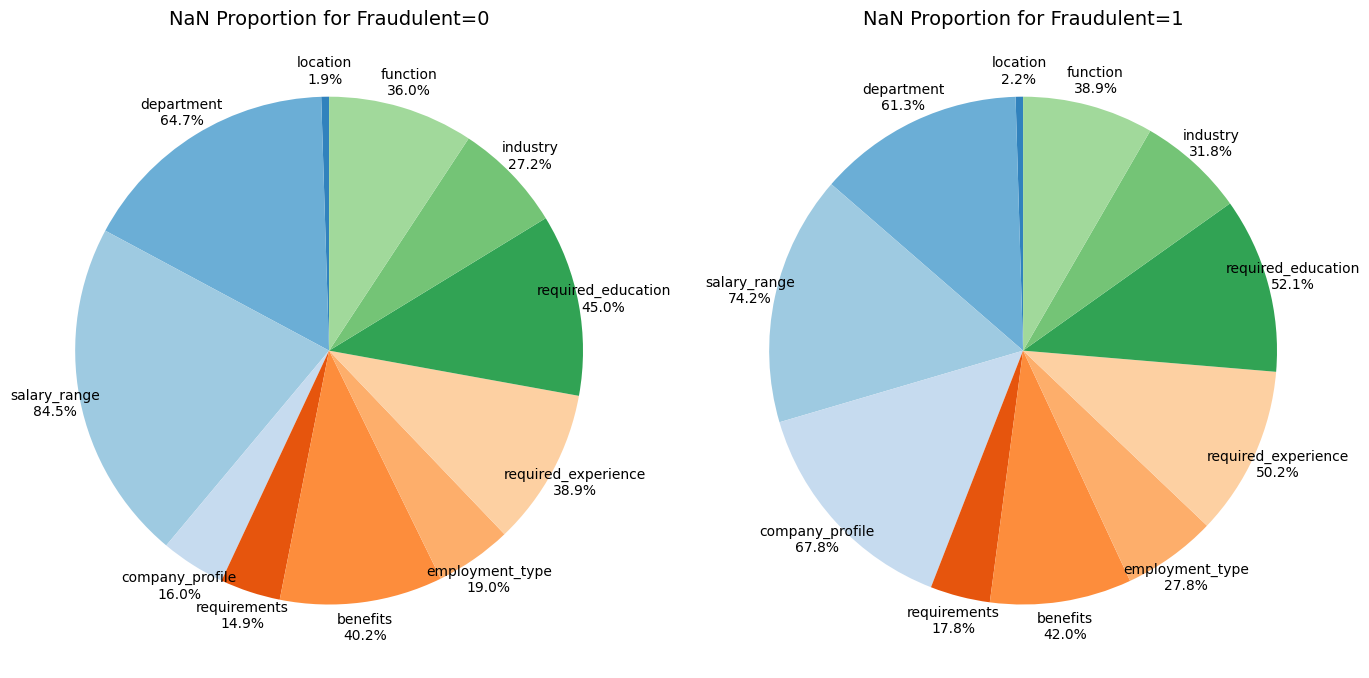

In [ ]:
# Calculate the proportion of NaN values for each target value
nan_proportions = df.groupby('fraudulent').apply(lambda x: x.isna().mean())

# Filter columns with NaN proportions less than 1%
nan_proportions_filtered = nan_proportions.loc[:, (nan_proportions > 0.01).any()]

colors = plt.cm.tab20c.colors

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for idx, (fraudulent_value, proportions) in enumerate(nan_proportions_filtered.iterrows()):
    ax = axs[idx]
    wedges, texts, autotexts = ax.pie(proportions, labels=None, startangle=90,
                                      autopct='', pctdistance=0.7, colors=colors)
    ax.set_title(f'NaN Proportion for Fraudulent={fraudulent_value}', fontsize=14)

    total = sum(proportions)
    for i, (wedge, autotext) in enumerate(zip(wedges, autotexts)):
        angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
        x = 1.1 * wedge.r * np.cos(np.deg2rad(angle))
        y = 1.1 * wedge.r * np.sin(np.deg2rad(angle))
        autotext.set_position((x, y))
        autotext.set_text(f'{proportions.index[i]}\n{proportions[i]:.1%}')

plt.tight_layout()
plt.show()

Based on the Nan Distributions seen above, we can observe that they are similar for most columns in both classes. The only noteable difference is in the the company_profile column, being much more frequently empty in Fraudulent samples.

We proceed with safely fill NaN values to an empty string.

In [ ]:
df.fillna('', inplace=True)

## 1.3 Average Word Count Analysis

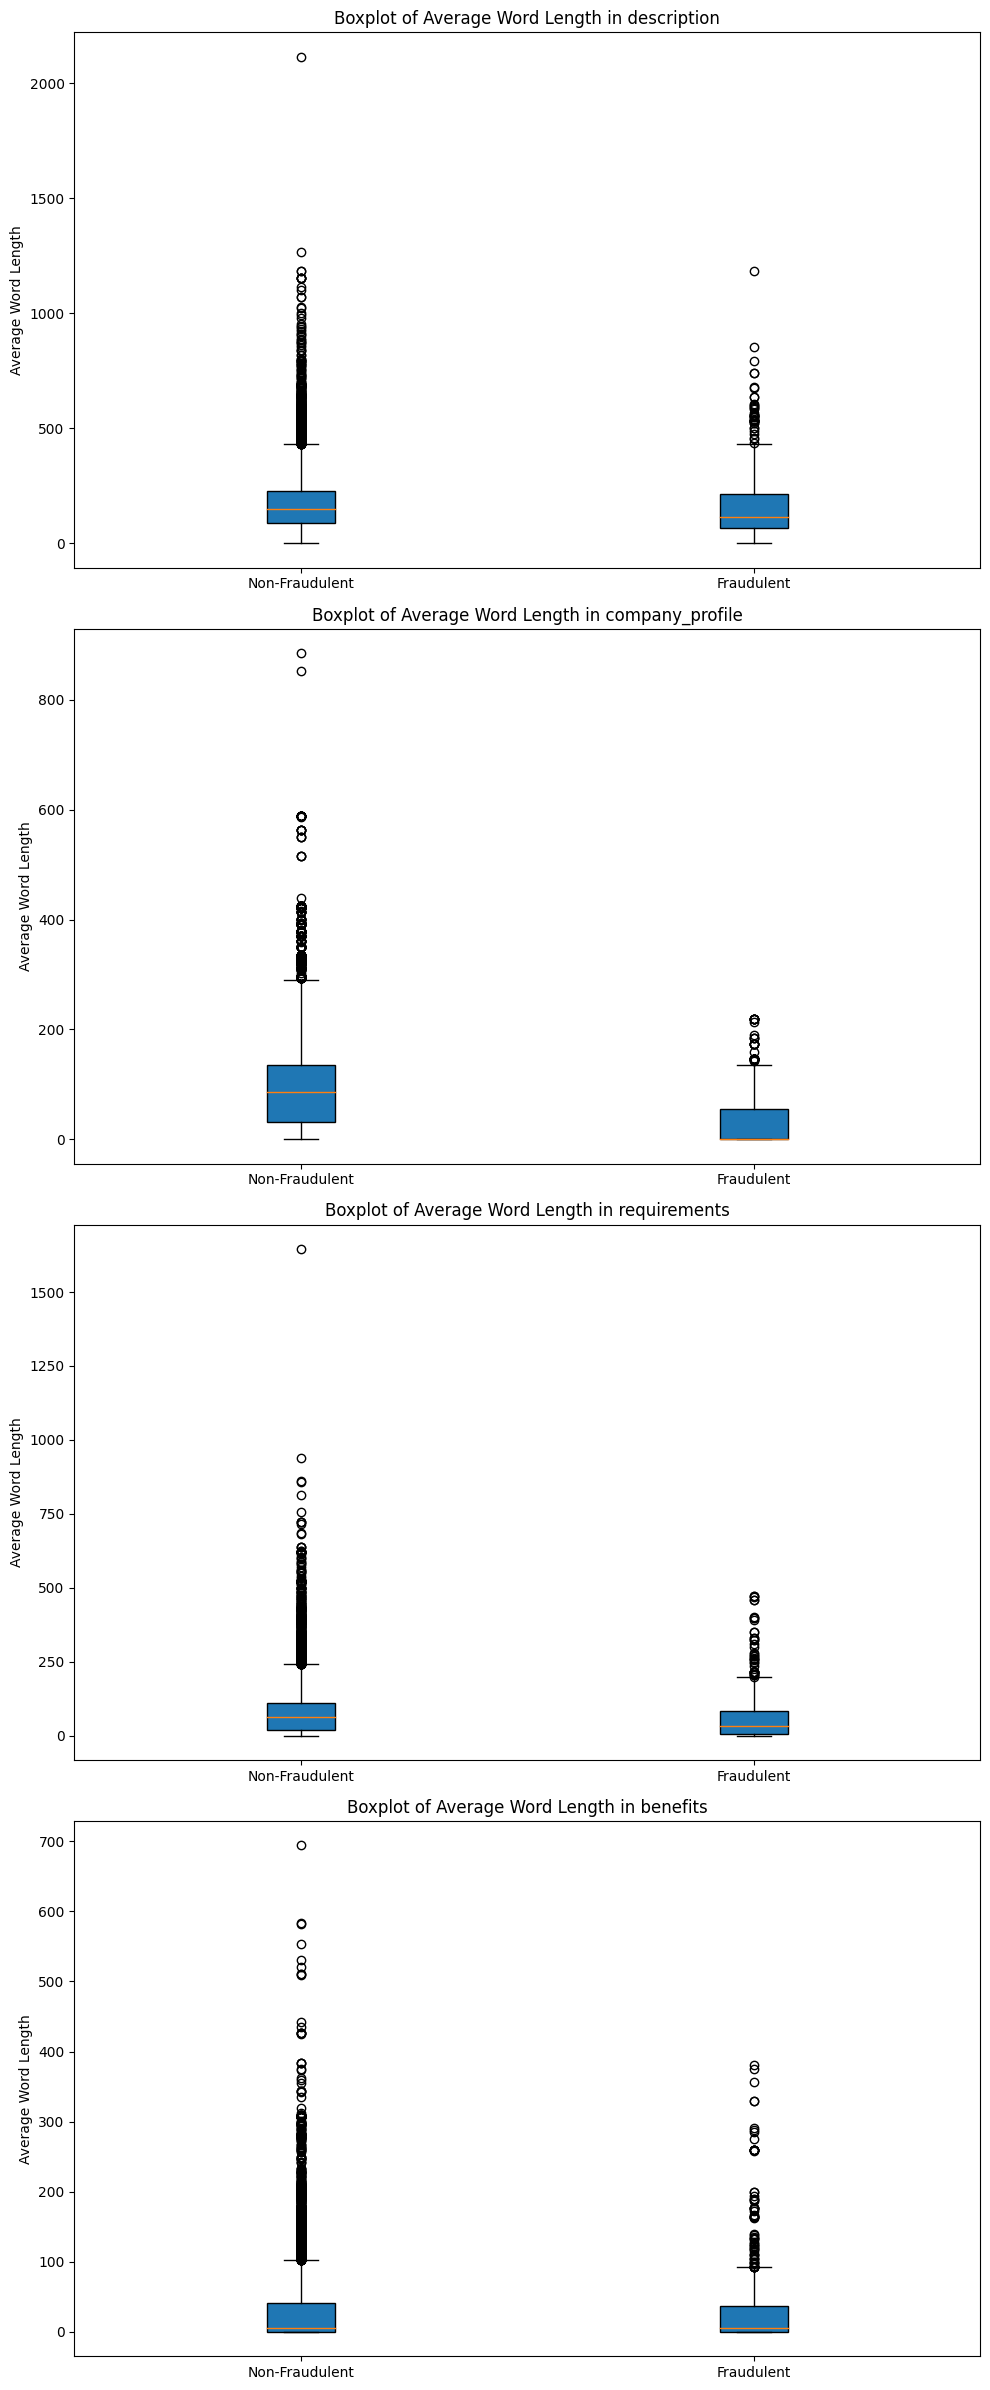

In [ ]:
for column in text_columns:
    for column in text_columns:
      df[column + '_word_length'] = df[column].apply(lambda x: 0 if pd.isnull(x) else len(str(x).split()))
      average_word_length[column] = df[column].apply(lambda x: 0 if pd.isnull(x) or len(str(x).split()) == 0 else sum(len(word) for word in str(x).split()) / len(str(x).split()))

fig, axs = plt.subplots(len(text_columns), 1, figsize=(10, 6 * len(text_columns)))

for i, column in enumerate(text_columns):
    # Separate data for each class
    df_non_fraudulent = df[df['fraudulent'] == 0]
    df_fraudulent = df[df['fraudulent'] == 1]

    # Prepare data for boxplot
    data = [df_non_fraudulent[column + '_word_length'], df_fraudulent[column + '_word_length']]
    axs[i].boxplot(data, patch_artist=True)

    axs[i].set_title(f'Boxplot of Average Word Length in {column}')
    axs[i].set_xticklabels(['Non-Fraudulent', 'Fraudulent'])
    axs[i].set_ylabel('Average Word Length')

plt.tight_layout()
plt.show()


Above we consider the longest text columns. We can see that there may be 2 outliers in terms of description and requirements. We choose to keep all data.

## 1.4 Token Frequency Analysis

In [ ]:
# Combine all text columns into one for analysis
df['combined_text'] = df[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Function to plot token frequency distribution
# This function takes a list of texts and a class label as input
# It tokenizes the text, computes the frequency distribution of tokens, and plots the distribution
def plot_token_frequency(texts, class_label):
    tokens = [word for sublist in texts for word in word_tokenize(sublist.lower())]
    freq_dist = FreqDist(tokens)
    freq_dist.plot(30, cumulative=False, title=f"Token Frequency Distribution for {class_label}")

# Function to plot token length distribution
# This function takes a list of texts and a class label as input
# It computes the length of tokens in each text, then plots the distribution of token lengths
def plot_token_length(texts, class_label):
    token_lengths = [len(word_tokenize(text)) for text in texts]
    plt.figure(figsize=(10, 6))
    sns.histplot(token_lengths, bins=50, kde=True)
    plt.title(f"Token Length Distribution for {class_label}")
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.show()

# Function to compute average token length
def avg_token_length(texts):
    return [len(word_tokenize(text)) for text in texts]


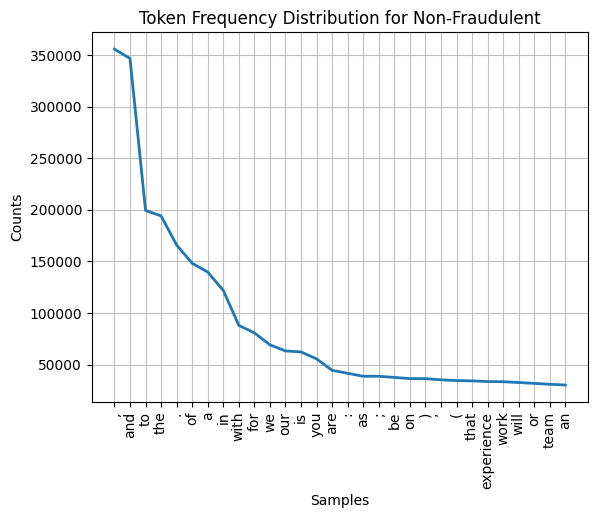

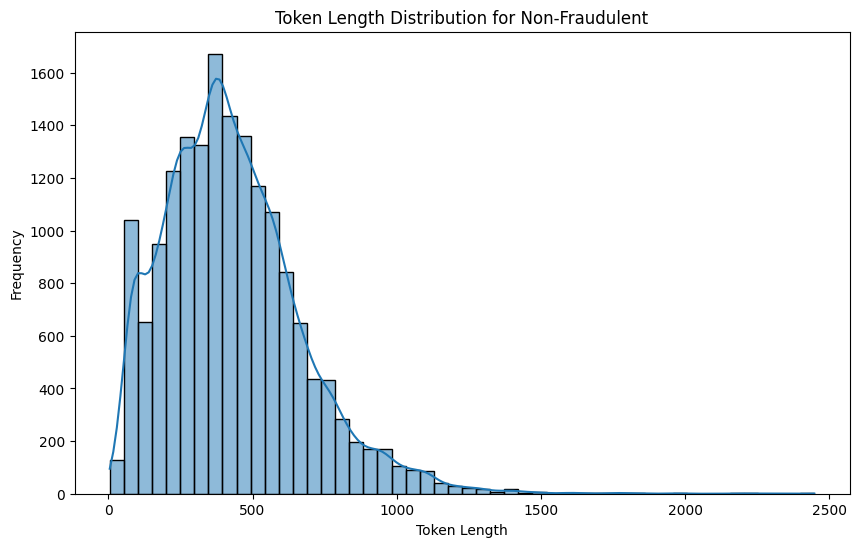

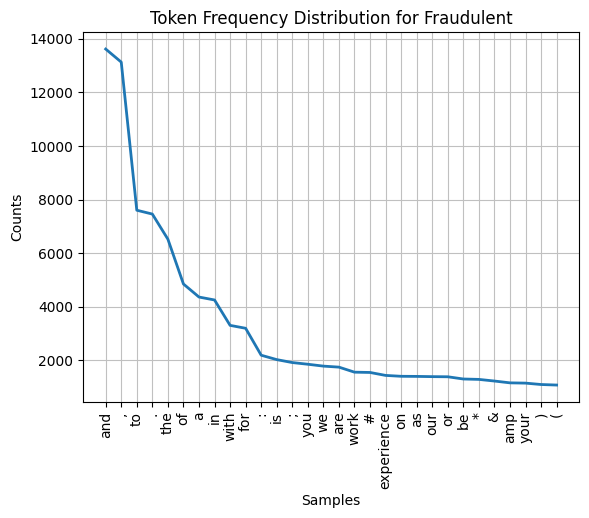

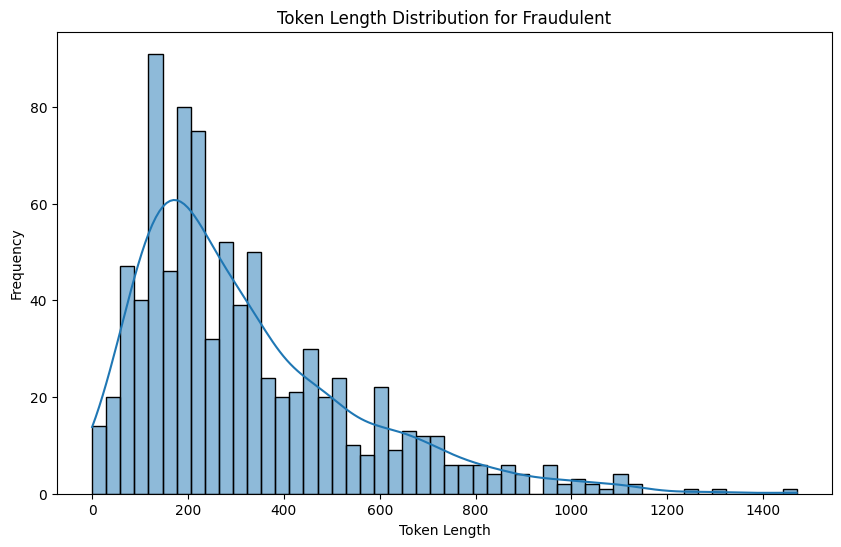

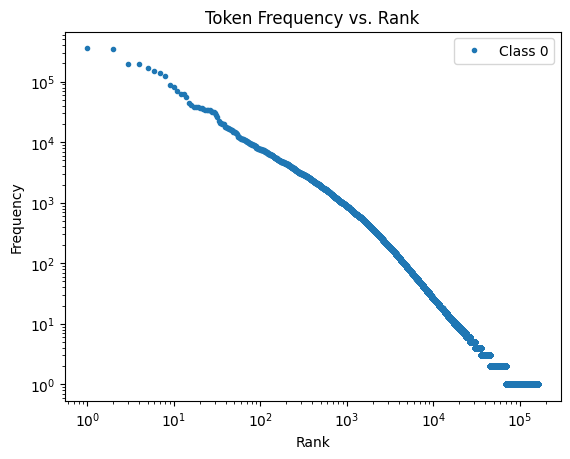

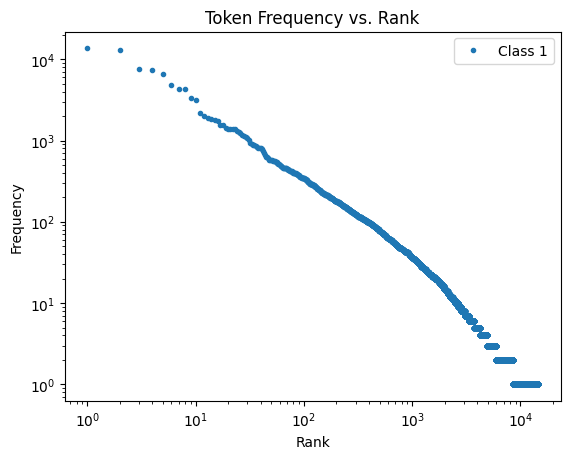

In [ ]:
# Dictionary defining class labels where 0 represents Non-Fraudulent and 1 represents Fraudulent
class_labels = {0: "Non-Fraudulent", 1: "Fraudulent"}
for class_value, class_label in class_labels.items():
  # Extract text data for the current class value
  class_texts = df[df[target_column] == class_value]['combined_text'].tolist()
  # Plot token frequency distribution for the current class
  plot_token_frequency(class_texts, class_label)
  # Plot token length distribution for the current class
  plot_token_length(class_texts, class_label)

for class_value in [0, 1]:
  # Extract text data for the current class value
  class_texts = df[df[target_column] == class_value]['combined_text'].tolist()

  # Tokenize the text and count token frequencies
  tokens = [word for sublist in class_texts for word in word_tokenize(sublist.lower())]
  counts = Counter(tokens)
  # Compute ranks and frequencies for Zipf's law visualization
  ranks = [rank for rank, word in enumerate(sorted(counts, key=counts.get, reverse=True), 1)]
  frequencies = sorted(list(counts.values()), reverse=True)
  # Plot token frequency vs. rank using log-log scale for Zipf's law
  plt.loglog(ranks, frequencies, marker=".", linestyle='None', label=f"Class {class_value}")
  plt.title('Token Frequency vs. Rank')
  plt.xlabel('Rank')
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

### Discussion of plots above

* **Token Frequency Distribution for Non-Fraudulent Job Postings:**
This plot shows the distribution of token frequencies (i.e., the number of occurrences of each word) in the text data of non-fraudulent job postings. It provides insights into the most common words used in non-fraudulent job postings.

* **Token Length Distribution for Non-Fraudulent Job Postings:**
This plot illustrates the distribution of token lengths (i.e., the number of words in each text) in non-fraudulent job postings. It helps to understand the typical length of job postings in the non-fraudulent category. We can see a pick at a length of 400. Also, it has the Gaussian distribution shape which suggests a degree of regularity and predictability in the lengths of non-fraudulent job postings' descriptions, making it a valuable characteristic to consider in the analysis of the dataset.

* **Token Frequency Distribution for Fraudulent Job Postings:**
Similar to the first plot, this one shows the distribution of token frequencies, but for fraudulent job postings. It helps identify common words used in fraudulent job postings. We can see that there is no significant difference between the this and the non-fraudulent one which be it would be hard to use this characteristic to detect frauduelnt posts.

* **Token Length Distribution for Fraudulent Job Postings:**
Similar to the second plot, this one displays the distribution of token lengths, but for fraudulent job postings. It gives insights into the typical length of job postings in the fraudulent category. We can see the there is a pick at aroung 140 which differs from the non-fraudulent one. It can be a valuable characteristic to detect the frauduelent posts.

* **Token Frequency vs. Rank Plot for Non-Fraudulent Job Postings (Zipf's law):**
This plot follows Zipf's law, which states that the frequency of any word is inversely proportional to its rank in the frequency table. It visualizes the frequency of tokens against their rank for non-fraudulent job postings, allowing observation of Zipfian behavior. It is decreasing which indicates that the distribution of word frequencies follows Zipf's law, with a few high-frequency words dominating the dataset and a long tail of low-frequency words.

* **Token Frequency vs. Rank Plot for Fraudulent Job Postings (Zipf's law):**
Similar to the fifth plot, this one follows Zipf's law for fraudulent job postings. It helps assess whether fraudulent job postings also exhibit Zipfian behavior in their token frequency distributions. It is also decreasing which means that few high-frequency words dominating the dataset and a long tail of low-frequency words.

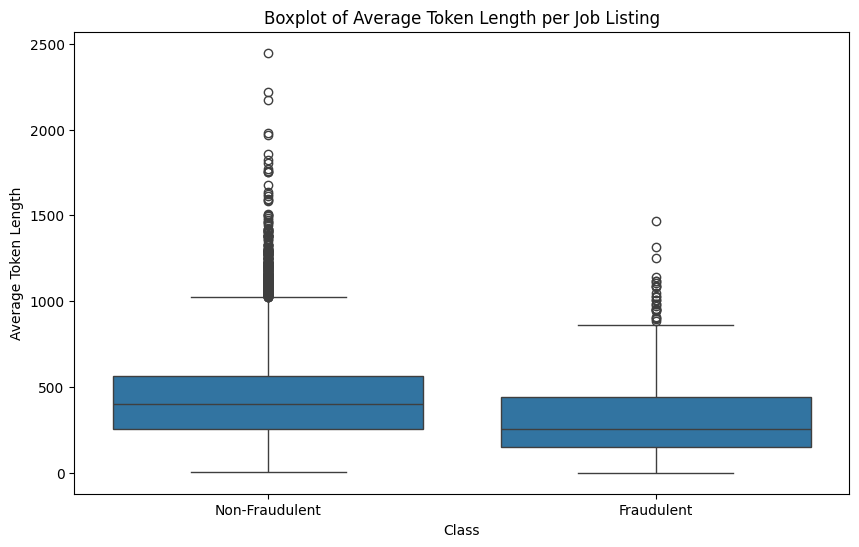

In [ ]:
# Adding a column with text class labels
df['class_label'] = df[target_column].map({0: "Non-Fraudulent", 1: "Fraudulent"})

# Computing average token length for each job listing
df['avg_token_length'] = df['combined_text'].apply(lambda x: len(word_tokenize(x)))

# Separating data into non-fraudulent and fraudulent job postings
df_non_fraudulent = df[df[target_column] == 0]
df_fraudulent = df[df[target_column] == 1]

# Generating a boxplot to visualize the distribution of average token lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x='class_label', y='avg_token_length', data=df)
plt.title('Boxplot of Average Token Length per Job Listing')
plt.xlabel('Class')
plt.ylabel('Average Token Length')
plt.show()


 The observed differences in mean, maximum, third quartile, and median of the average token length between non-fraudulent and fraudulent job postings suggest disparities in the length and depth of text content, reflecting differences in content quality, transparency, and the underlying intentions of the posting authors.Also, the non-fraudulent one is more spread out, it goes up to 2500 while the frauduelent one only goes up to around 1500. It can be explained by the diffrences mentionned previously and also by the fact that we have a lots less frauduelent posts than the non-fraudulent posts in our dataset.

## 1.5 Feature Analysis With Respect To Classes

In this section we analyse the data in more detail while primarily focusing on the labels in the class in connection with some of the feature we are feeding into our models. The purpose of this analysis is to find potential unawanted biases that we feed into the models during training.

Percentage of Non Fraudulent Postings: 95%
Percentage Fraudulent Postings: 5%.


Text(0.5, 1.0, 'Number of Instances Fraudulent vs Non-Fraudulent')

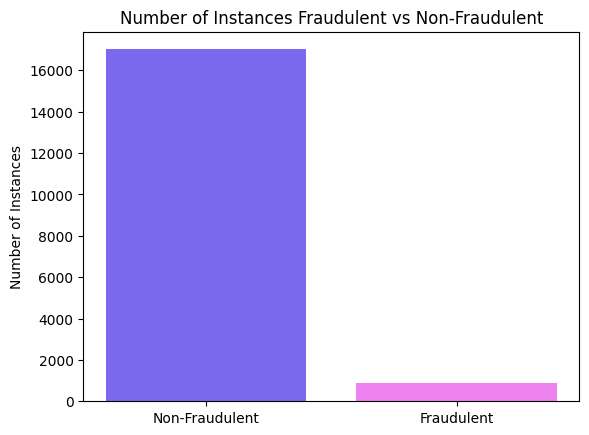

In [ ]:
#To not have issues with collides, we load a fresh instance of the dataset for the analysis
full_data=pd.read_csv("fake_job_postings.csv")

#Collect the amounts of fraudulent and non-fraudulent data
non_frauds=full_data[full_data["fraudulent"] == 0]
frauds=full_data[full_data["fraudulent"] == 1]
x=[0, 1]


plt.bar([0], len(non_frauds), color="mediumslateblue")
plt.bar([1], len(frauds), color="violet")
percentage_non_fraud="{:.0%}".format(len(non_frauds)/len(full_data))
percentage_fraud="{:.0%}".format(len(frauds)/len(full_data))
print(f"Percentage of Non Fraudulent Postings: {percentage_non_fraud}\nPercentage Fraudulent Postings: {percentage_fraud}.")
plt.xticks(x, ["Non-Fraudulent", "Fraudulent"])
plt.ylabel('Number of Instances')
plt.title('Number of Instances Fraudulent vs Non-Fraudulent')

The first plot shows the ratio of the fraudulent class and non-fraudulent class to asses how balanced the dataset is generally. As shown in the plot, the balance is very unbalances with only 5% belonging to the fraudulent class and 95% to the non-fraudulent class. The danger of such a heavily unbalanced dataset it that the model just learns to predict a single class and ignore the other one completely. Since we have quite a large dataset overall, we experiment with leaving out a certain percentage of the non-fraudulent class and asses the performance changes. Additionally, we use the macro average of the metrics to have a more differenciated impression of the model's performance.

In [ ]:
#We create a DataFrame that will store the length, description and the binary variable of fraudulent. We will use this dataframe for plotting the lengths w.r.t their classes and their frequecies in the next cell
description_length_df=pd.DataFrame()
filtered_descriptions=full_data.dropna(subset=["fraudulent", "description"])
description_length_df["length"]=filtered_descriptions["description"].str.split().str.len()
description_length_df = description_length_df[description_length_df["length"] != 0]
description_length_df["description"]=full_data["description"]
description_length_df["fraudulent"]=full_data["fraudulent"]
description_length_df.reset_index(inplace=True, drop=True)
description_length_df

<ipython-input-27-189c8031a304>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  description_length_df["description"]=full_data["description"]
<ipython-input-27-189c8031a304>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  description_length_df["fraudulent"]=full_data["fraudulent"]


,length,description,fraudulent
0,124,"Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff",0
1,315,"Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you! We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about delivering a world class product and excellent customer service.Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!We are entering the next growth stage of our business and growing quickly internationally. Therefore, the position is bursting with opportunity for the right person entering the business at the right time. 90 Seconds, the worlds Cloud Video Production Service - http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. Fast, affordable, and all managed seamlessly in the cloud from purchase to publish. 90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing network of over 2,000 rated video professionals in over 50 countries and dedicated production success teams in 5 countries guaranteeing video project success 100%. It's as easy as commissioning a quick google adwords campaign.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal, L'oreal, Sony and Barclays and has offices in Auckland, London, Sydney, Tokyo &amp; Singapore.Our Auckland office is based right in the heart of the Wynyard Quarter Innovation Precinct - GridAKL!",0
2,50,"Our client, located in Houston, is actively seeking an experienced Commissioning Machinery Assistant that possesses strong supervisory skills and has an attention to detail. A strong dedication to safety is a must. The ideal candidate will execute all activities while complying with quality requirements and health, environmental, and safety regulations.",0
3,346,"THE COMPANY: ESRI – Environmental Systems Research InstituteOur passion for improving quality of life through geography is at the heart of everything we do. Esri’s geographic information system (GIS) technology inspires and enables governments, universities and businesses worldwide to save money, lives and our environment through a deeper understanding of the changing world around them.Carefully managed growth and zero debt give Esri stability that is uncommon in today's volatile business world. Privately held, we offer exceptional benefits, competitive salaries, 401(k) and profit-sharing 

The shortest description in our dataset has 1 words.
The longest description in our dataset has 2115 words.


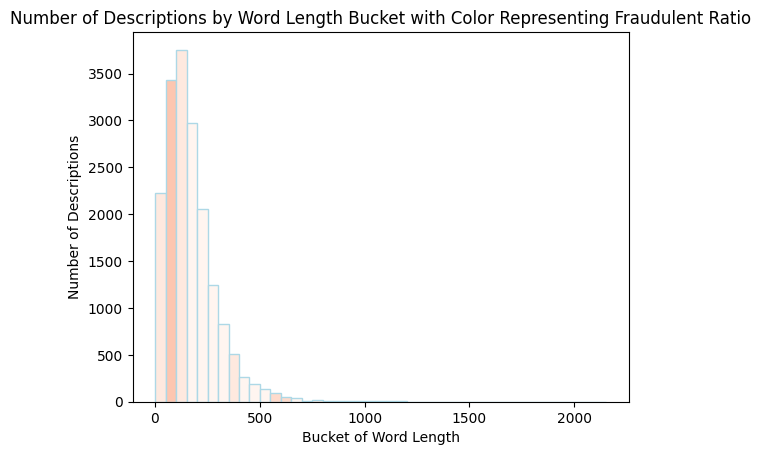

In [ ]:
cmap = plt.cm.Reds
#Select longest and shortest lengths of descriptions
shortest_value = min(description_length_df["length"].tolist())
longest_value = max(description_length_df["length"].tolist())
print(f"The shortest description in our dataset has {shortest_value} words.\nThe longest description in our dataset has {longest_value} words.")

#Count the number of descriptions that fit into a certain bucket
length_counts = description_length_df["length"].value_counts().reset_index()
length_counts.columns = ['length', 'count']
length_counts["fraudulent"] = description_length_df["fraudulent"]

#We choose a bucket size of 50
buckets = list(range(shortest_value, longest_value + 50, 50))

length_counts['buckets'] = pd.cut(length_counts['length'], bins=buckets)
bucket_counts = length_counts.groupby('buckets').agg({'count': 'sum', 'fraudulent': 'sum'}).reset_index()
total_fraudulent_instances = length_counts['fraudulent'].sum()
bucket_counts['fraudulent_ratio'] = bucket_counts['fraudulent'] / total_fraudulent_instances
fraudulent_colors = cmap(bucket_counts["fraudulent_ratio"])
bucket_starts = [bucket.left for bucket in bucket_counts["buckets"]]
bucket_ends = [bucket.right for bucket in bucket_counts["buckets"]]
bar_heights = bucket_counts["count"]
bar_widths = [end - start for start, end in zip(bucket_starts, bucket_ends)]

#Create and plot the barplot with color scheme
plt.bar(bucket_starts, bar_heights, width=bar_widths, align='edge', edgecolor="lightblue", color=fraudulent_colors)
plt.xlabel('Bucket of Word Length')
plt.ylabel('Number of Descriptions')
plt.title('Number of Descriptions by Word Length Bucket with Color Representing Fraudulent Ratio')
plt.show()


The plot above represents the amount of descriptions belonging to a certain bucket of lengths calculated by word. The colouring of indicates the ratio between fraudulent instances in a bucket vs the total amount of fraudulent instances. This way, we can analyse if all of the fraudulent instances are in the same bucket or well distributed. To create the buckets, we first obtain the shortest and longest description and can see that there is a big difference. Too short instances could be outliers, and "dirty" samples. If we have too many outliers the model will not be able to learn efficiently. However, some outliers will give the model more robust. Coming back to our example, We can see that most fraudulent instances can be found in the second bucket (100-150 words). Some other fraudulent instances can also be found in the longer instances. That the instances are spread out over different lengths indicates that there is no inherent strong bias regarding the length of the descriptions. We also employ this information when we attempt to generate fraudulent examples using Llama.

In [ ]:
#Filter out non numeric rows from the salary_range column
filter_non_numeric = lambda x: re.match(r'^\d+-\d+$', str(x)) is not None
salaries = pd.DataFrame()

#Drop elements that do not have a value for fraudulent or for salary_range
filtered_salaries=full_data.dropna(subset=["fraudulent", "salary_range"])
filtered_salaries=filtered_salaries[filtered_salaries["salary_range"].apply(filter_non_numeric)]
salaries["salary_range"] = filtered_salaries["salary_range"]
salaries["fraudulent"] = filtered_salaries["fraudulent"]
salaries["bucket"] = np.nan
salaries.reset_index(inplace=True)

#Create the buckets and fill them. We opt for step siye 10000 but this can be adapted
bucket_starts = [int(bucket.split("-")[0]) for bucket in filtered_salaries["salary_range"]]
bucket_ends = [int(bucket.split("-")[1]) for bucket in filtered_salaries["salary_range"]]
bucket_range = range(int(min(bucket_starts)), int(max(bucket_ends)) + 1, 10000)
for idx, (bucket_start, bucket_end) in tqdm(enumerate(zip(bucket_starts, bucket_ends)), total=len(bucket_starts)):
    for lower_value in bucket_range:
        upper_value = lower_value + 9999
        if bucket_start <=lower_value :
            salaries.loc[idx, "bucket"] = lower_value
            break

100%|██████████| 2841/2841 [00:00<00:00, 10631.40it/s]


         bucket  count  fraudulent
0           0.0    195    0.027027
1       10000.0    346    0.270270
2       20000.0    318    0.022523
3       30000.0    427    0.270270
4       40000.0    388    0.117117
5       50000.0    331    0.049550
6       60000.0    181    0.049550
7       70000.0    146    0.076577
8       80000.0    145    0.040541
9       90000.0     69    0.004505
10     100000.0     89    0.018018
11     110000.0     15    0.000000
12     120000.0     35    0.009009
13     130000.0     15    0.004505
14     140000.0     21    0.004505
15     150000.0     10    0.000000
16     160000.0      2    0.000000
17     170000.0      5    0.000000
18     180000.0     10    0.000000
19     190000.0      1    0.000000
20     200000.0     17    0.000000
21     210000.0      1    0.000000
22     220000.0      1    0.000000
23     240000.0      5    0.000000
24     250000.0      9    0.031532
25     300000.0     11    0.000000
26     320000.0      2    0.000000
27     340000.0     

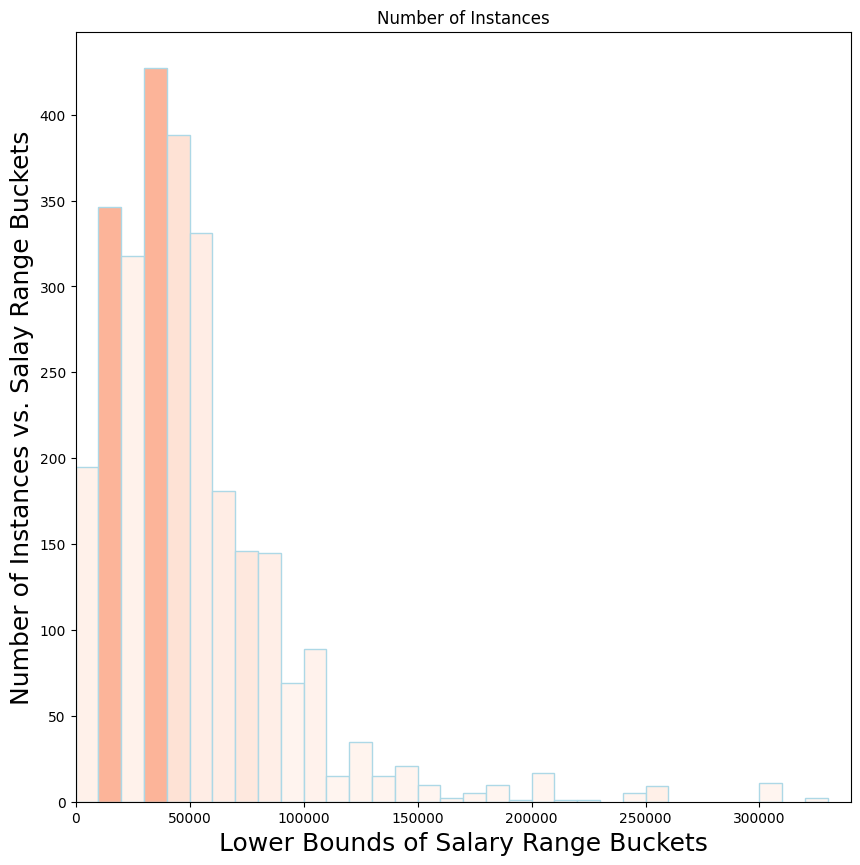

In [ ]:
#Bucket the salaries and
bucket_counts_salaries=pd.DataFrame()
bucket_counts_salaries= salaries.groupby('bucket').size().reset_index()
bucket_counts_salaries.rename(columns={0: 'count'}, inplace=True)
total_fraudulent_instances = salaries['fraudulent'].sum()
frauds_salaries = salaries.groupby('bucket')["fraudulent"].agg(fraudulent=lambda x: sum(x)/total_fraudulent_instances if total_fraudulent_instances != 0 else 0).reset_index()
bucket_counts_salaries=bucket_counts_salaries.merge(frauds_salaries)
bucket_counts_salaries_sorted = bucket_counts_salaries.sort_values(by='bucket')
print(bucket_counts_salaries_sorted)

#Plot and add color. A darker color indicates a higher number of fraudulent instances
plt.figure(figsize=(10, 10))
plt.bar(bucket_counts_salaries_sorted["bucket"][:-2], bucket_counts_salaries_sorted["count"][:-2], width=10000, align='edge', edgecolor="lightblue", color=cmap(bucket_counts_salaries_sorted["fraudulent"]))
plt.xlim(left=0, right=340000)
plt.xlabel('Lower Bounds of Salary Range Buckets',  fontsize=18)
plt.ylabel('Number of Instances vs. Salay Range Buckets',  fontsize=18)
plt.title('Number of Instances')
plt.show()

Next, we analyse the salary ranges that are covered in the job descriptions. We display the bucket egdes on the x axis and the number of elements on the y axis. The color scheme (also in the follwing plots) indicates the ratio of fraudulent instances that are in the bucket compared to the total number of fraudulent instances in the dataset. To accomodate overlapping ranges, we opt to bucket based on the lower value of the range. Since some instances also include noise in terms of date names (e.g "Okt") we omit these instances for this analysis. We also crop the plot a bit on the x-axis to make the differences more visible. Missing values can be seen in the printed dataframe. We can see that fraudulent datapoints usually have a lower salay range but some outliers can also be found in the higher ranges. We can conclude that there is a slight bias that we feed into the model. However, we do not deem this to be a non-desirable bias, since we think it could be an indicator of a fraudulent postings.

   location  count  fraudulent
0        AE     54    0.001181
1        AL      1    0.000000
2        AM      2    0.000000
3        AR      9    0.000000
4        AT     14    0.000000
..      ...    ...         ...
85       US  10656    0.861865
86       VI      3    0.000000
87       VN      4    0.000000
88       ZA     40    0.001181
89       ZM      2    0.000000

[90 rows x 3 columns]


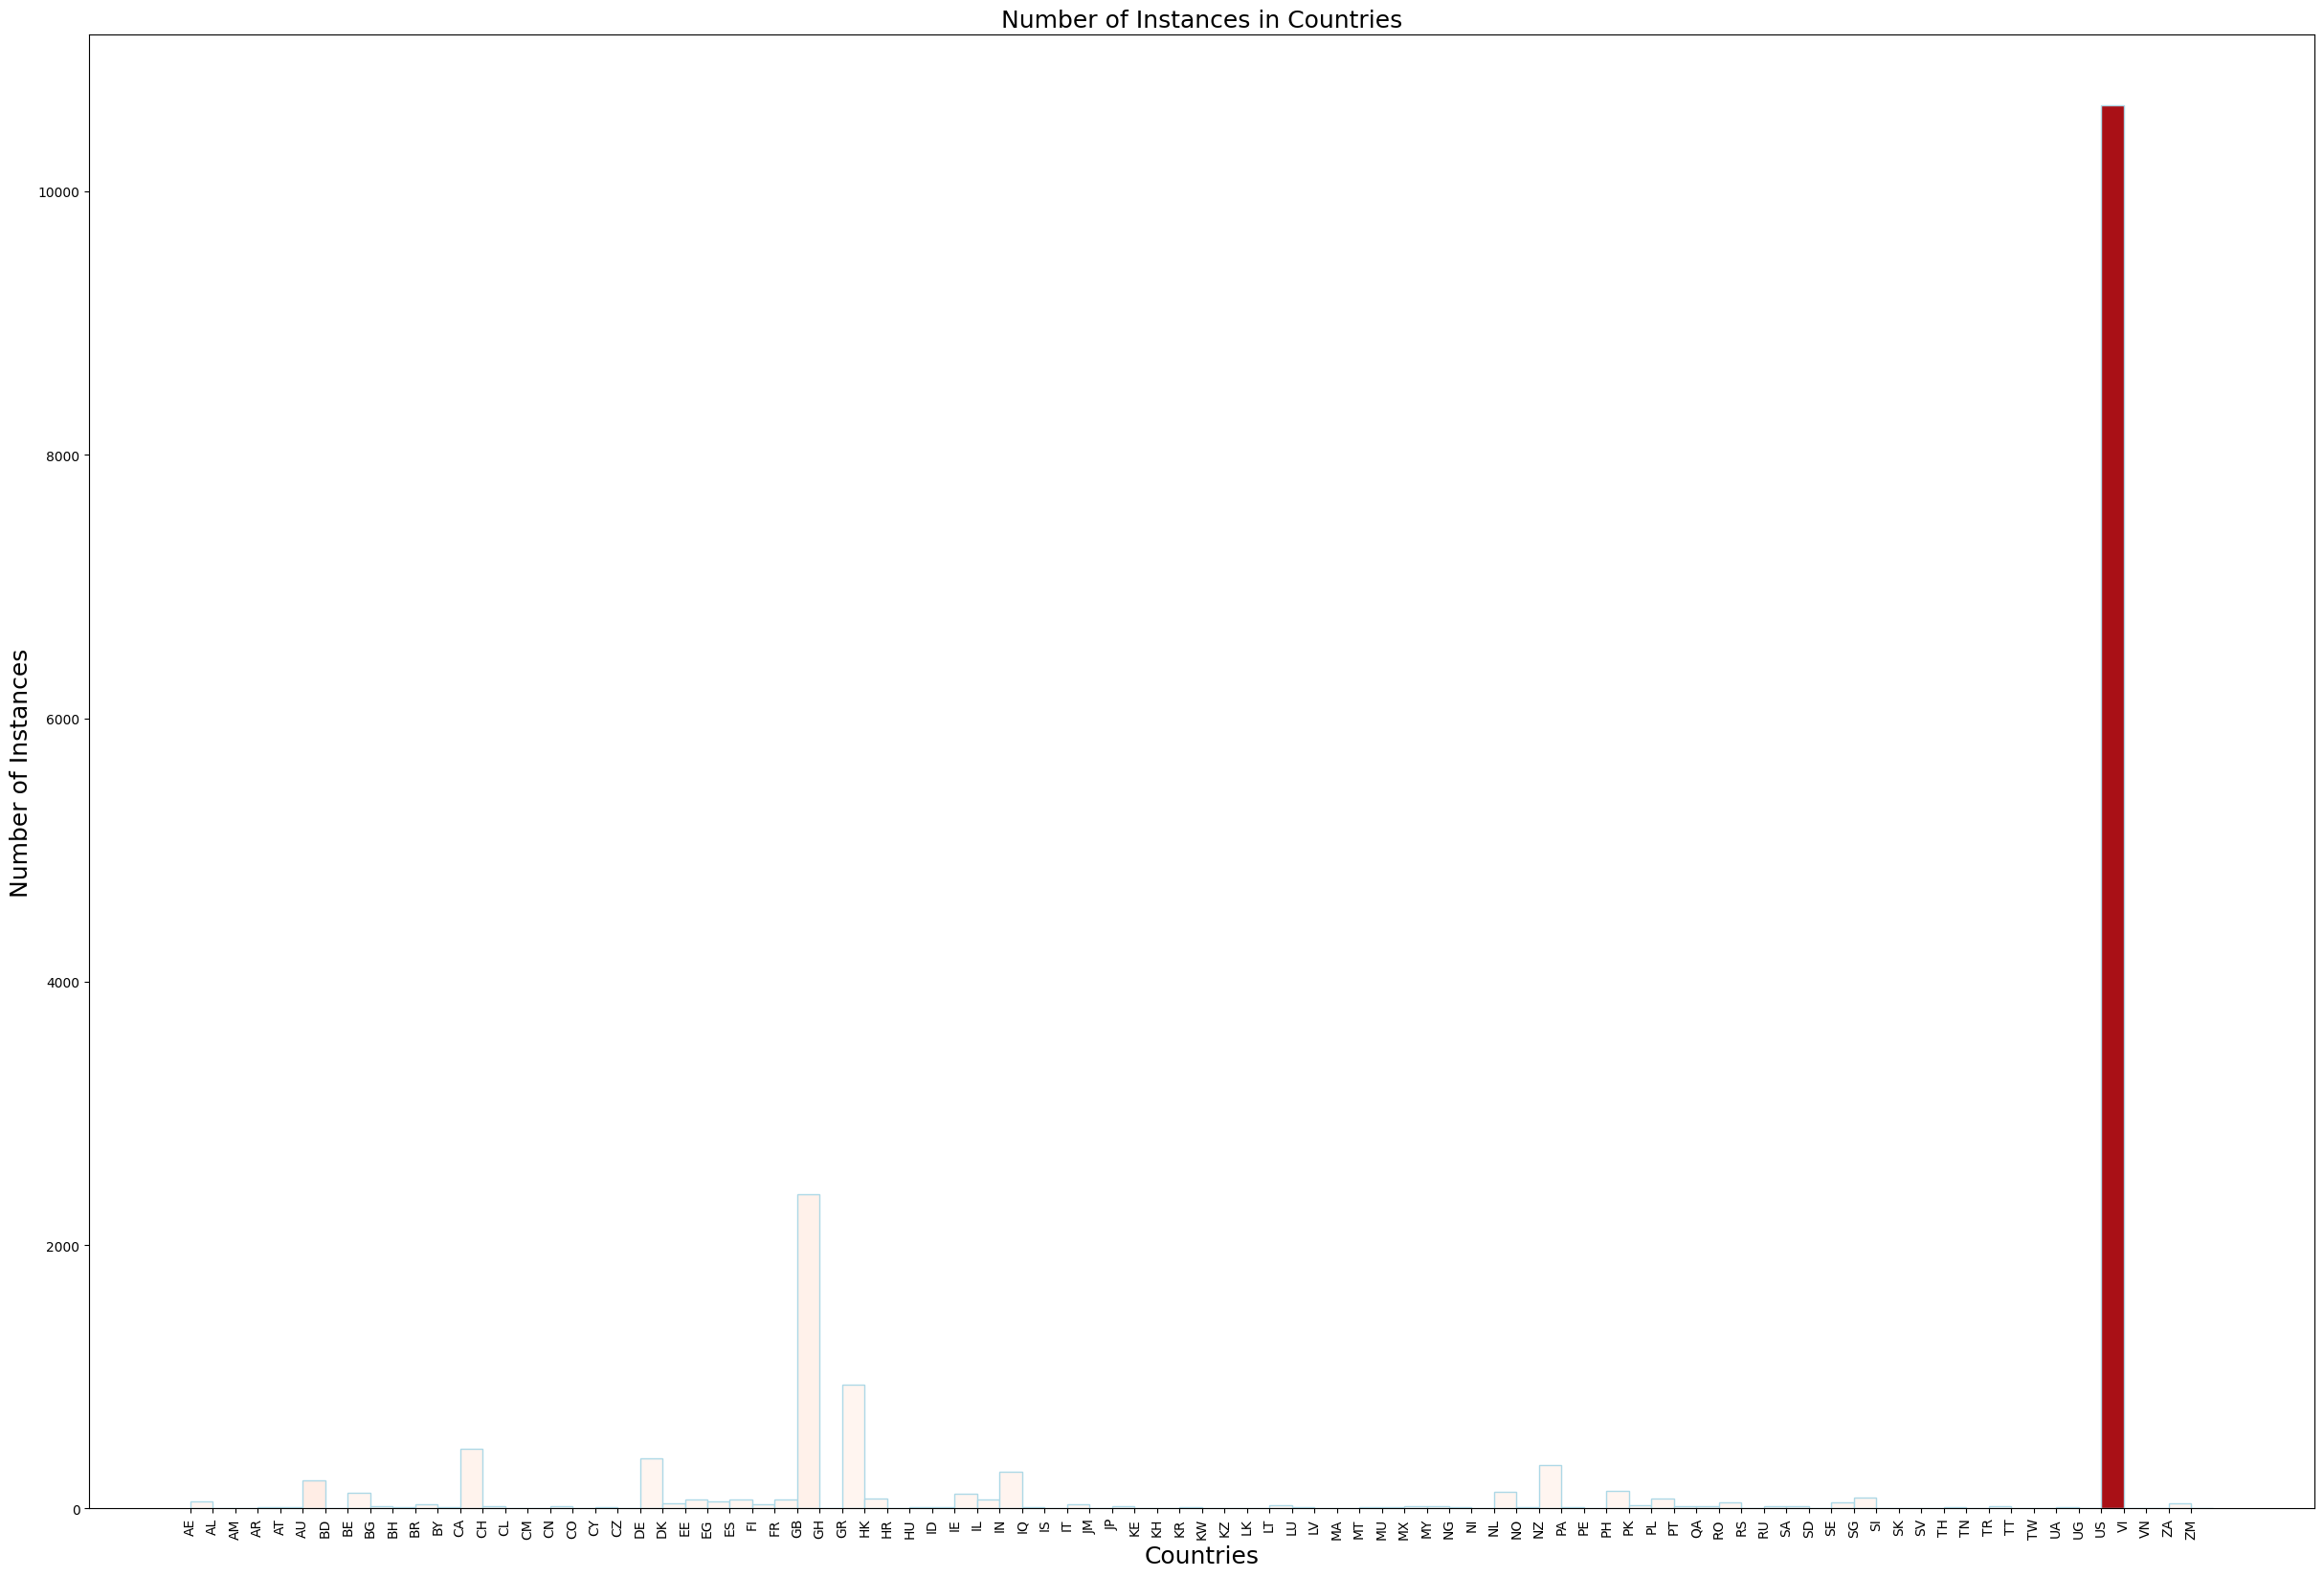

In [ ]:
#We also analyse the countries that the fraudulent elements come from
countries=pd.DataFrame()
filtered_countries=full_data.dropna(subset=["fraudulent","location"])
countries["location"]=filtered_countries["location"].apply(lambda x: x.split(", ")[0])
countries["fraudulent"]=filtered_countries["fraudulent"]
country_counts= countries.groupby('location').size().reset_index()

#Calculate fraudulent ratio
total_fraudulent_instances = countries['fraudulent'].sum()
frauds_countries = countries.groupby('location')["fraudulent"].agg(fraudulent=lambda x: sum(x)/total_fraudulent_instances if total_fraudulent_instances != 0 else 0).reset_index()

country_counts=country_counts.merge(frauds_countries)
country_counts.rename(columns={0: 'count'}, inplace=True)
plt.figure(figsize=(30, 20))
print(country_counts)
plt.bar(country_counts.index, country_counts["count"], width=1, align='edge', edgecolor="lightblue", color=cmap(country_counts["fraudulent"]))
plt.xticks(country_counts.index, country_counts["location"], rotation=90)
plt.xlabel('Countries',  fontsize=18)
plt.title('Number of Instances in Countries',  fontsize=18)
plt.ylabel('Number of Instances',  fontsize=18)
plt.show()

The above plot showcases the amount of datapoints that are from certain countried. We can see that overall there is a very strong bias toward samples coming from the US. Additionally, most of the fraudulent dataspoints are also from the US. This introduces a bias into the models that we don't think is desirable. Even though the model still has to learn to rely on other features to differentiate the sample coming from the US, the model will have a strong bias towards datapoints that do not come from the US.

                   required_education  count  fraudulent
0                    Associate Degree    274    0.014458
1                   Bachelor's Degree   5145    0.240964
2                       Certification    170    0.045783
3                           Doctorate     26    0.002410
4           High School or equivalent   2080    0.409639
5                     Master's Degree    416    0.074699
6                        Professional     74    0.009639
7   Some College Coursework Completed    102    0.007229
8         Some High School Coursework     27    0.048193
9                         Unspecified   1397    0.146988
10                         Vocational     49    0.000000
11                Vocational - Degree      6    0.000000
12            Vocational - HS Diploma      9    0.000000
  required_experience  count  fraudulent
0           Associate   2297    0.097448
1            Director    389    0.039443
2         Entry level   2697    0.415313
3           Executive    141    0.0232

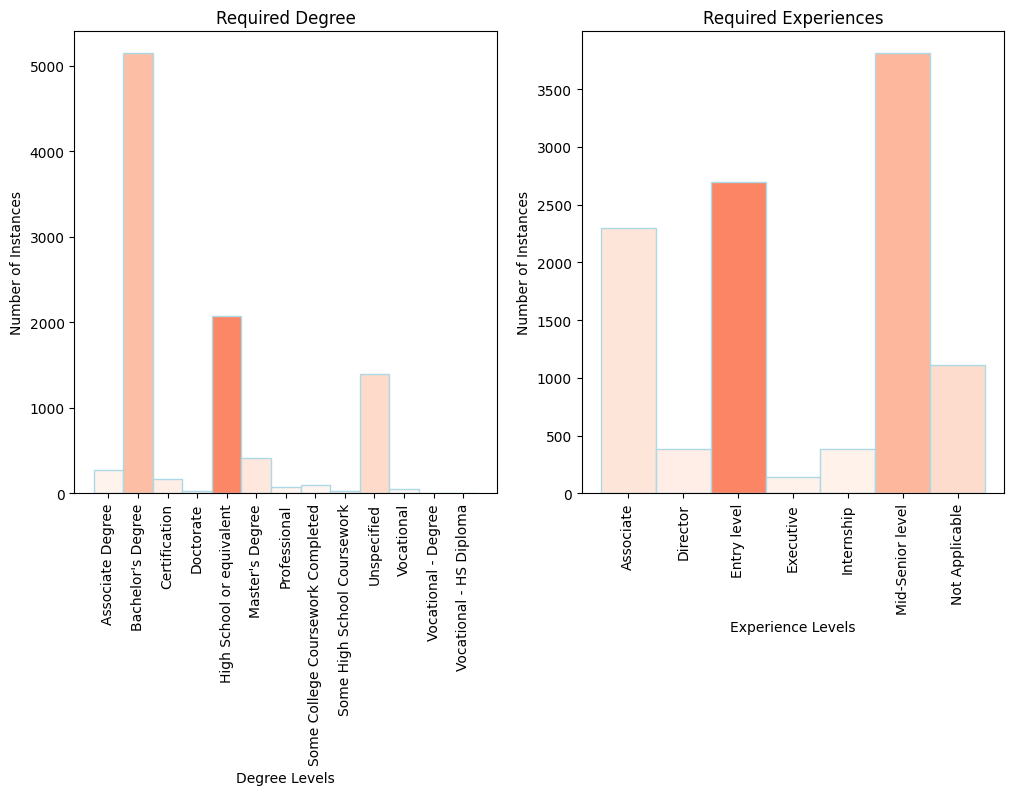

In [ ]:
#Degree requirements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
degrees=pd.DataFrame()
filtered_degrees=full_data.dropna(subset=["fraudulent", "required_education"])
degrees["required_education"]=filtered_degrees["required_education"].apply(lambda x: x.split(", ")[0])
degrees["fraudulent"]=filtered_degrees["fraudulent"]
degree_counts= degrees.groupby('required_education').size().reset_index()
print(degrees.groupby('required_education')["fraudulent"])
total_fraudulent_instances = degrees['fraudulent'].sum()
frauds_degrees = degrees.groupby('required_education')["fraudulent"].agg(fraudulent=lambda x: sum(x)/total_fraudulent_instances if total_fraudulent_instances != 0 else 0).reset_index()
degree_counts=degree_counts.merge(frauds_degrees)
degree_counts.rename(columns={0: 'count'}, inplace=True)

print(degree_counts)



#Experience requirements
experience=pd.DataFrame()
filtered_experiences=full_data.dropna(subset=["fraudulent", "required_experience"])
experience["required_experience"]=filtered_experiences["required_experience"].apply(lambda x: x.split(", ")[0])
experience["fraudulent"]=filtered_experiences["fraudulent"]
experience_counts= experience.groupby('required_experience').size().reset_index()
total_fraudulent_instances = experience['fraudulent'].sum()
frauds_experience = experience.groupby('required_experience')["fraudulent"].agg(fraudulent=lambda x: sum(x)/total_fraudulent_instances if total_fraudulent_instances != 0 else 0).reset_index()
experience_counts=experience_counts.merge(frauds_experience)
experience_counts.rename(columns={0: 'count'}, inplace=True)

print(experience_counts)

#Plot
ax1.bar(degree_counts.index, degree_counts["count"], width=1, align='center', edgecolor="lightblue", color=cmap(degree_counts["fraudulent"]))
ax1.set_xticks(degree_counts.index, degree_counts["required_education"], rotation=90)
ax1.set_title("Required Degree")
ax1.set_xlabel("Degree Levels")
ax1.set_ylabel("Number of Instances")



ax2.bar(experience_counts.index, experience_counts["count"], width=1, align='center', edgecolor="lightblue", color=cmap(experience_counts["fraudulent"]))
ax2.set_xticks(experience_counts.index, experience_counts["required_experience"], rotation=90)
ax2.set_title("Required Experiences")
ax2.set_xlabel("Experience Levels")
ax2.set_ylabel("Number of Instances")
plt.show()

In the above plot we show the different required degrees and their frequency in the dataset on the y axis. Overall the Bachelor's degree is the most required degree to find a job across fraudulent and non-fraudulent jobs. 24% of all the fraudulent jobs that include the required degree, expect the applicant to have a Bachelor's degree. However, the most prominent required degree for fraudulent jobs is a High School or equivalent degree. Equivalently, the experience most requested by frauduelent job listings is Entry Level. These plots reveal, that the fraudulent job postings might mostly be dedicated to younger and more impressionable applicants and that the required degree and experience are desirable feature to learn. Most indicative for these features to be important is also that the highest number of fraudulent datapoints are not, like in the countries related plot, in the overall most frequent plot.

Number of Countries:131
                             industry  count  fraudulent
0                          Accounting    159    0.096447
1                   Airlines/Aviation     63    0.001692
3                           Animation      5    0.003384
4                   Apparel & Fashion     97    0.003384
6                          Automotive    120    0.008460
..                                ...    ...         ...
119                Telecommunications    342    0.043993
122  Transportation/Trucking/Railroad     53    0.005076
123                         Utilities     33    0.001692
126                       Warehousing     51    0.001692
127                         Wholesale     11    0.001692

[62 rows x 3 columns]


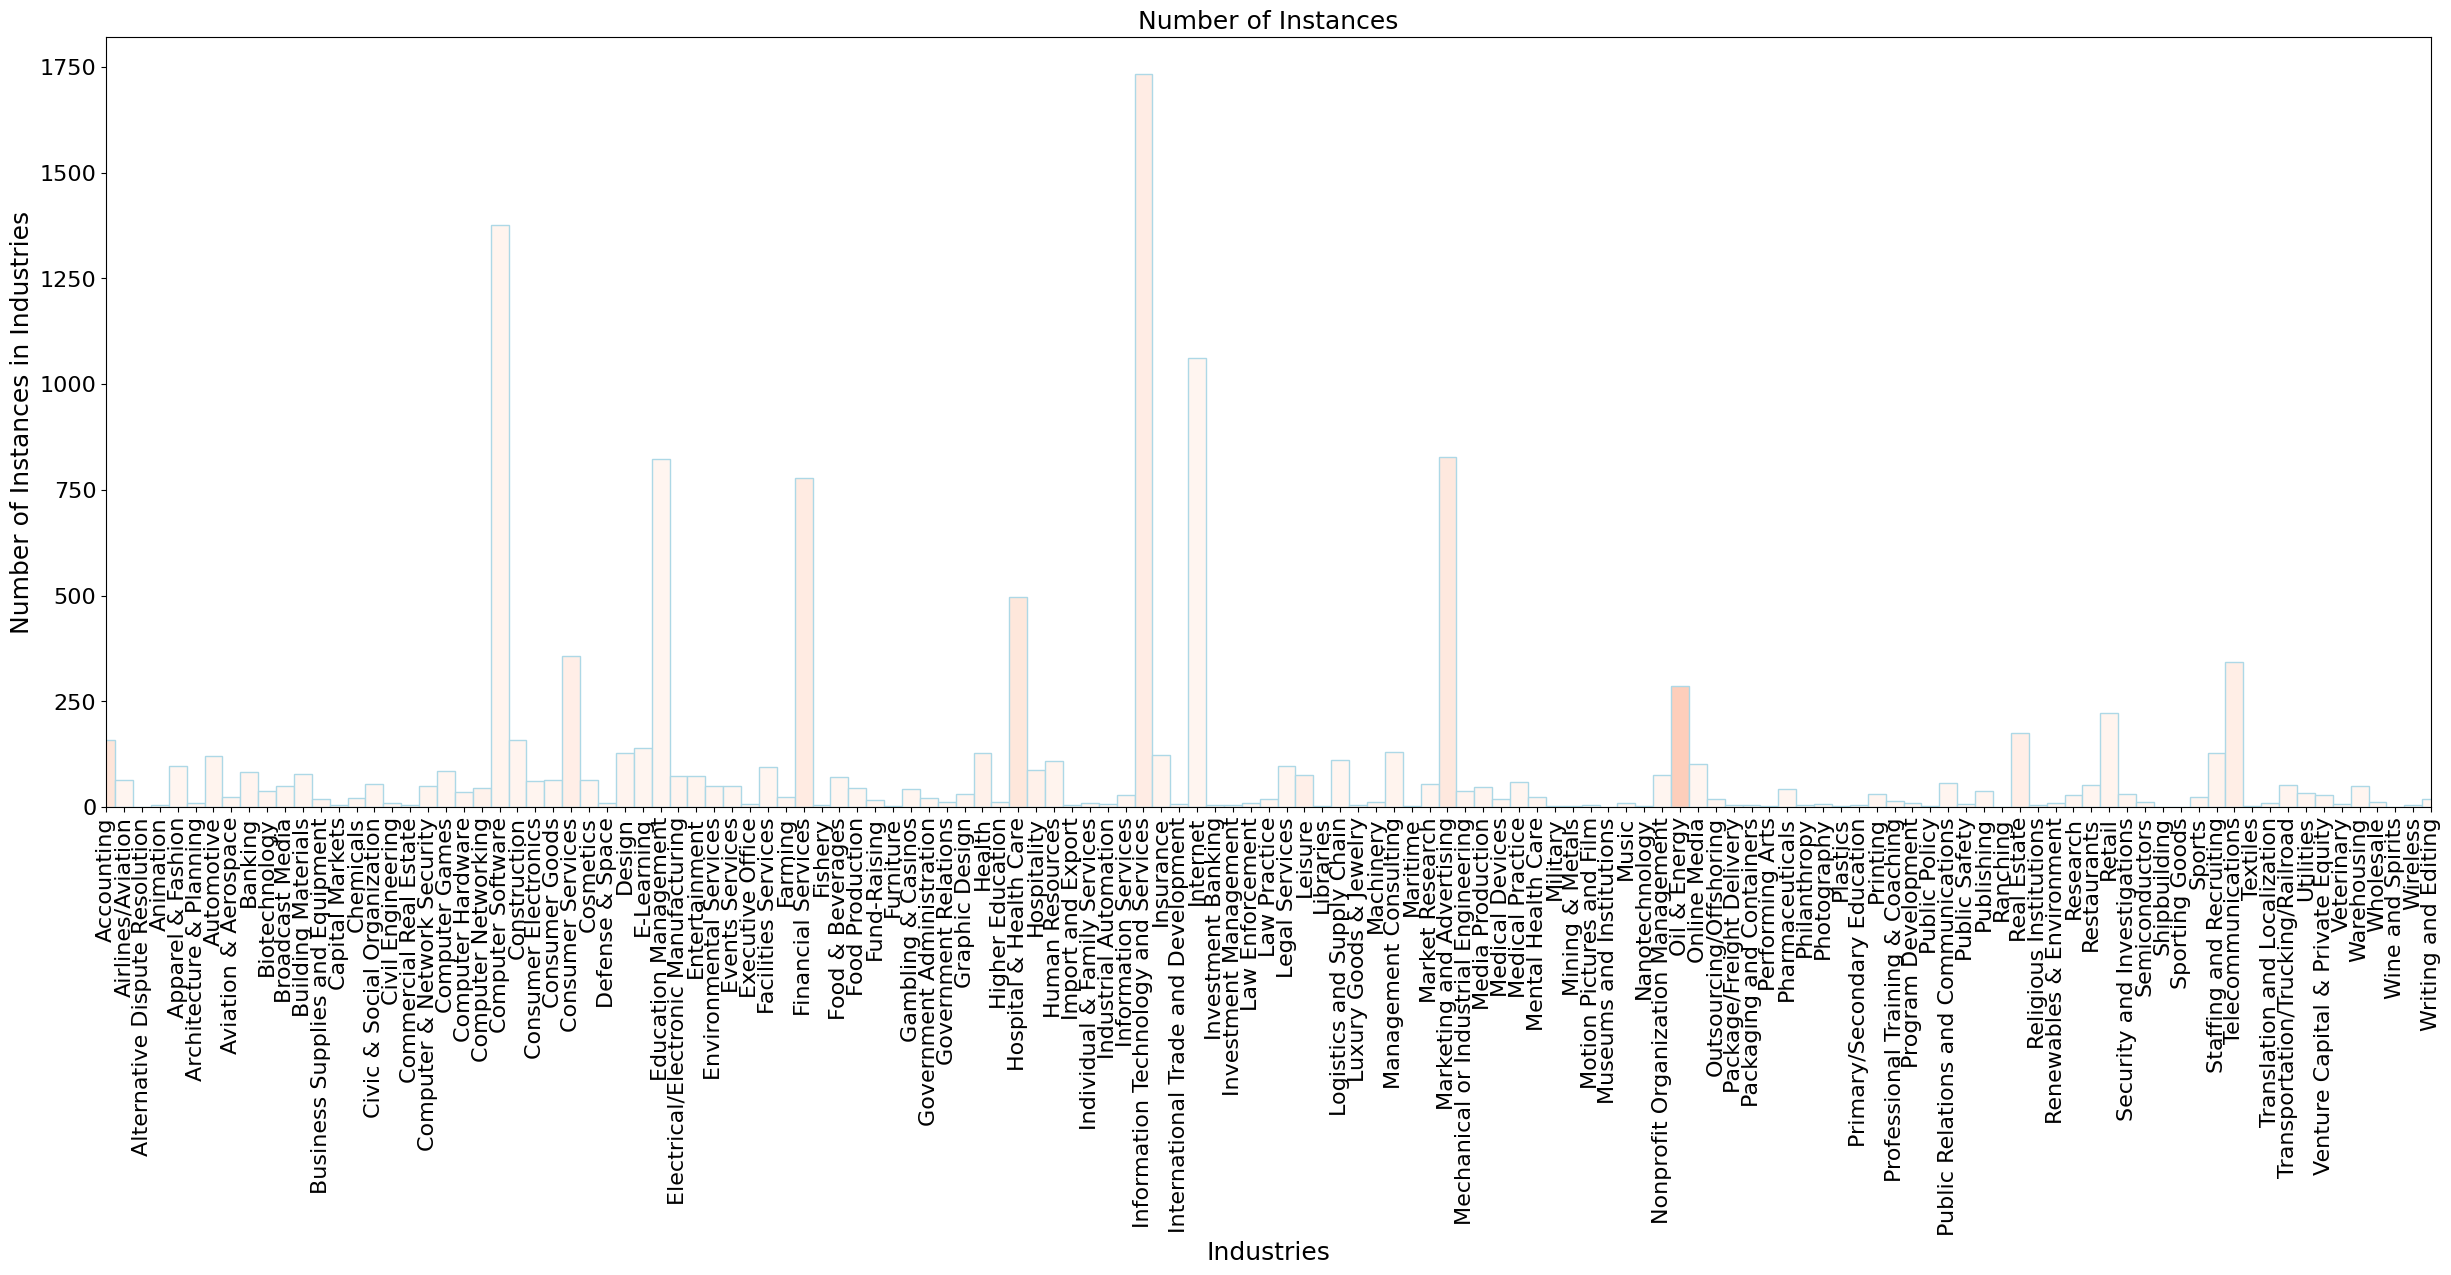

In [ ]:
#Analyse the different industries and their fraudulent and non-fraudulent instances
industry=pd.DataFrame()
filtered_industries=full_data.dropna(subset=["fraudulent", "industry"])
industry["industry"]=filtered_industries["industry"].apply(lambda x: x.split(", ")[0])
industry["fraudulent"]=filtered_industries["fraudulent"]
print("Number of Countries:{0}".format(len(set(industry["industry"].tolist()))))
industry_counts= industry.groupby('industry').size().reset_index()

#Calculate the ratio of fraudulent instances vs all fraudulent instances
total_fraudulent_instances = industry['fraudulent'].sum()
frauds_industries = industry.groupby('industry')["fraudulent"].agg(fraudulent=lambda x: sum(x)/total_fraudulent_instances if total_fraudulent_instances != 0 else 0).reset_index()

industry_counts=industry_counts.merge(frauds_industries)
industry_counts.rename(columns={0: 'count'}, inplace=True)
print(industry_counts[industry_counts["fraudulent"] > 0.0])

#Plot and use color coding
plt.figure(figsize=(30, 10))
plt.xlim(left=0)
plt.bar(industry_counts.index, industry_counts["count"], width=1, align='center', edgecolor="lightblue", color=cmap(industry_counts["fraudulent"]))
plt.xticks(industry_counts.index, industry_counts["industry"], rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Industries',  fontsize=18)
plt.ylabel('Number of Instances in Industries',  fontsize=18)
plt.title('Number of Instances',  fontsize=18)
plt.show()

The industries could give an indication what kind of jobs scammers target the most. From the distribution table, we can see that the fraudulent job postings are quite well distributed. However, we can see that the Oil and Energy industry includes the most fraudulent instances, although overall it is not the most frequent industry. This indicates that a job positng from the Oil and Energy industry should make the model suspect a fake posting and is relevant for the learning process.

   telecommuting  count  fraudulent
0              0  17113    0.926097
1              1    767    0.073903


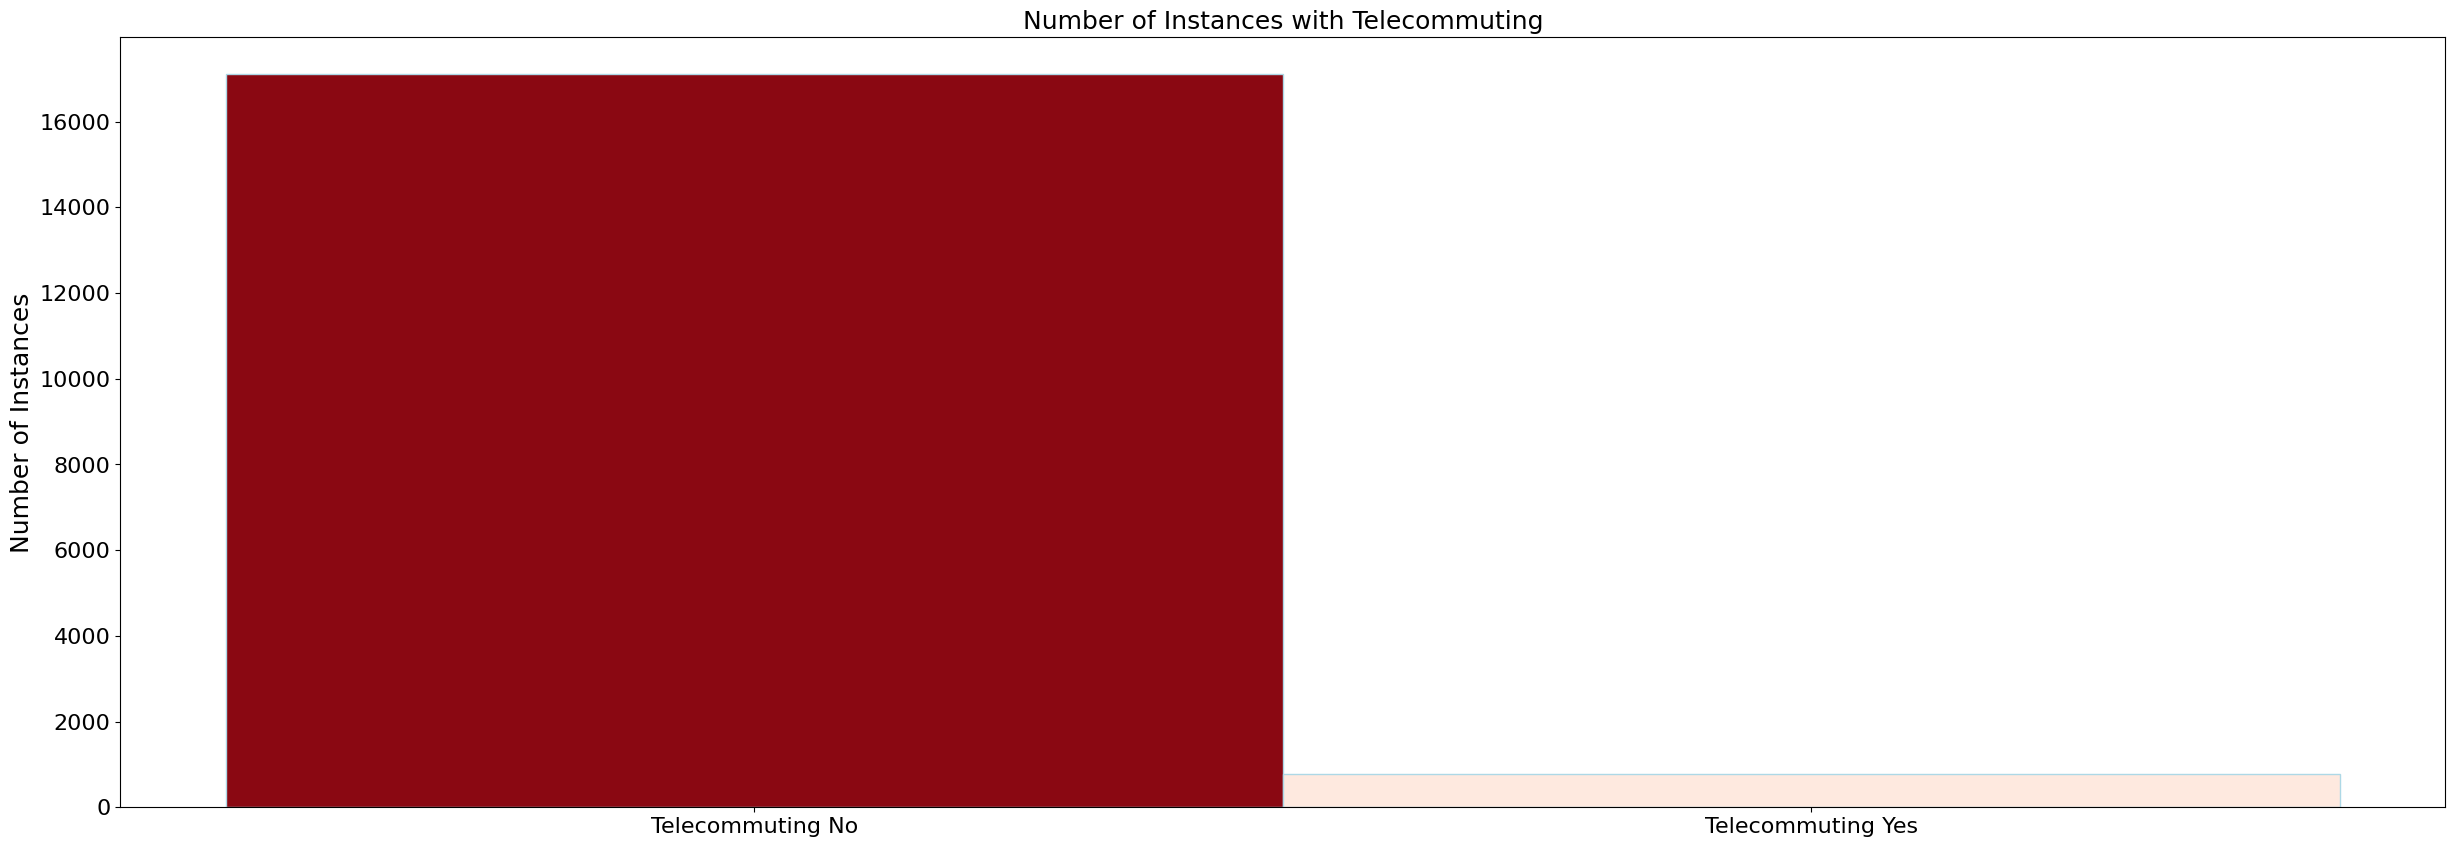

In [ ]:
#Analysis of the Telecommuting feature.
telecommuting=pd.DataFrame()
filtered_tele=full_data.dropna(subset=["fraudulent", "telecommuting"])
telecommuting["fraudulent"]=filtered_tele["fraudulent"]
telecommuting["telecommuting"]=filtered_tele["telecommuting"]
tele_counts= telecommuting.groupby('telecommuting').size().reset_index()


#Calculate the number of total fraudulent instances and prepare the colouring
total_fraudulent_instances = telecommuting['fraudulent'].sum()
frauds_tele = telecommuting.groupby('telecommuting')["fraudulent"].agg(fraudulent=lambda x: sum(x)/total_fraudulent_instances if total_fraudulent_instances != 0 else 0).reset_index()

#Plot
tele_counts=tele_counts.merge(frauds_tele)
tele_counts.rename(columns={0: 'count'}, inplace=True)
print(tele_counts)
plt.figure(figsize=(30, 10))
plt.yticks(fontsize=16)
plt.bar(tele_counts.index, tele_counts["count"], width=1, align='center', edgecolor="lightblue", color=cmap(tele_counts["fraudulent"]))
plt.xticks(tele_counts.index, ["Telecommuting No", "Telecommuting Yes"], fontsize=16)
plt.title('Number of Instances with Telecommuting',  fontsize=18)
plt.ylabel('Number of Instances',  fontsize=18)
plt.show()

The plot above shows the availability of teleecommuting which is a binary variable in our dataset. Overall we can see that most jobs do not offer a telecommuting option. Additionally, most of the instances that are fraudulent surprisingly also do not have telecommuting. This indicates that this variable is not very expressive for the model to learn from.  

   has_company_logo  count  fraudulent
0                 0   3660     0.67321
1                 1  14220     0.32679


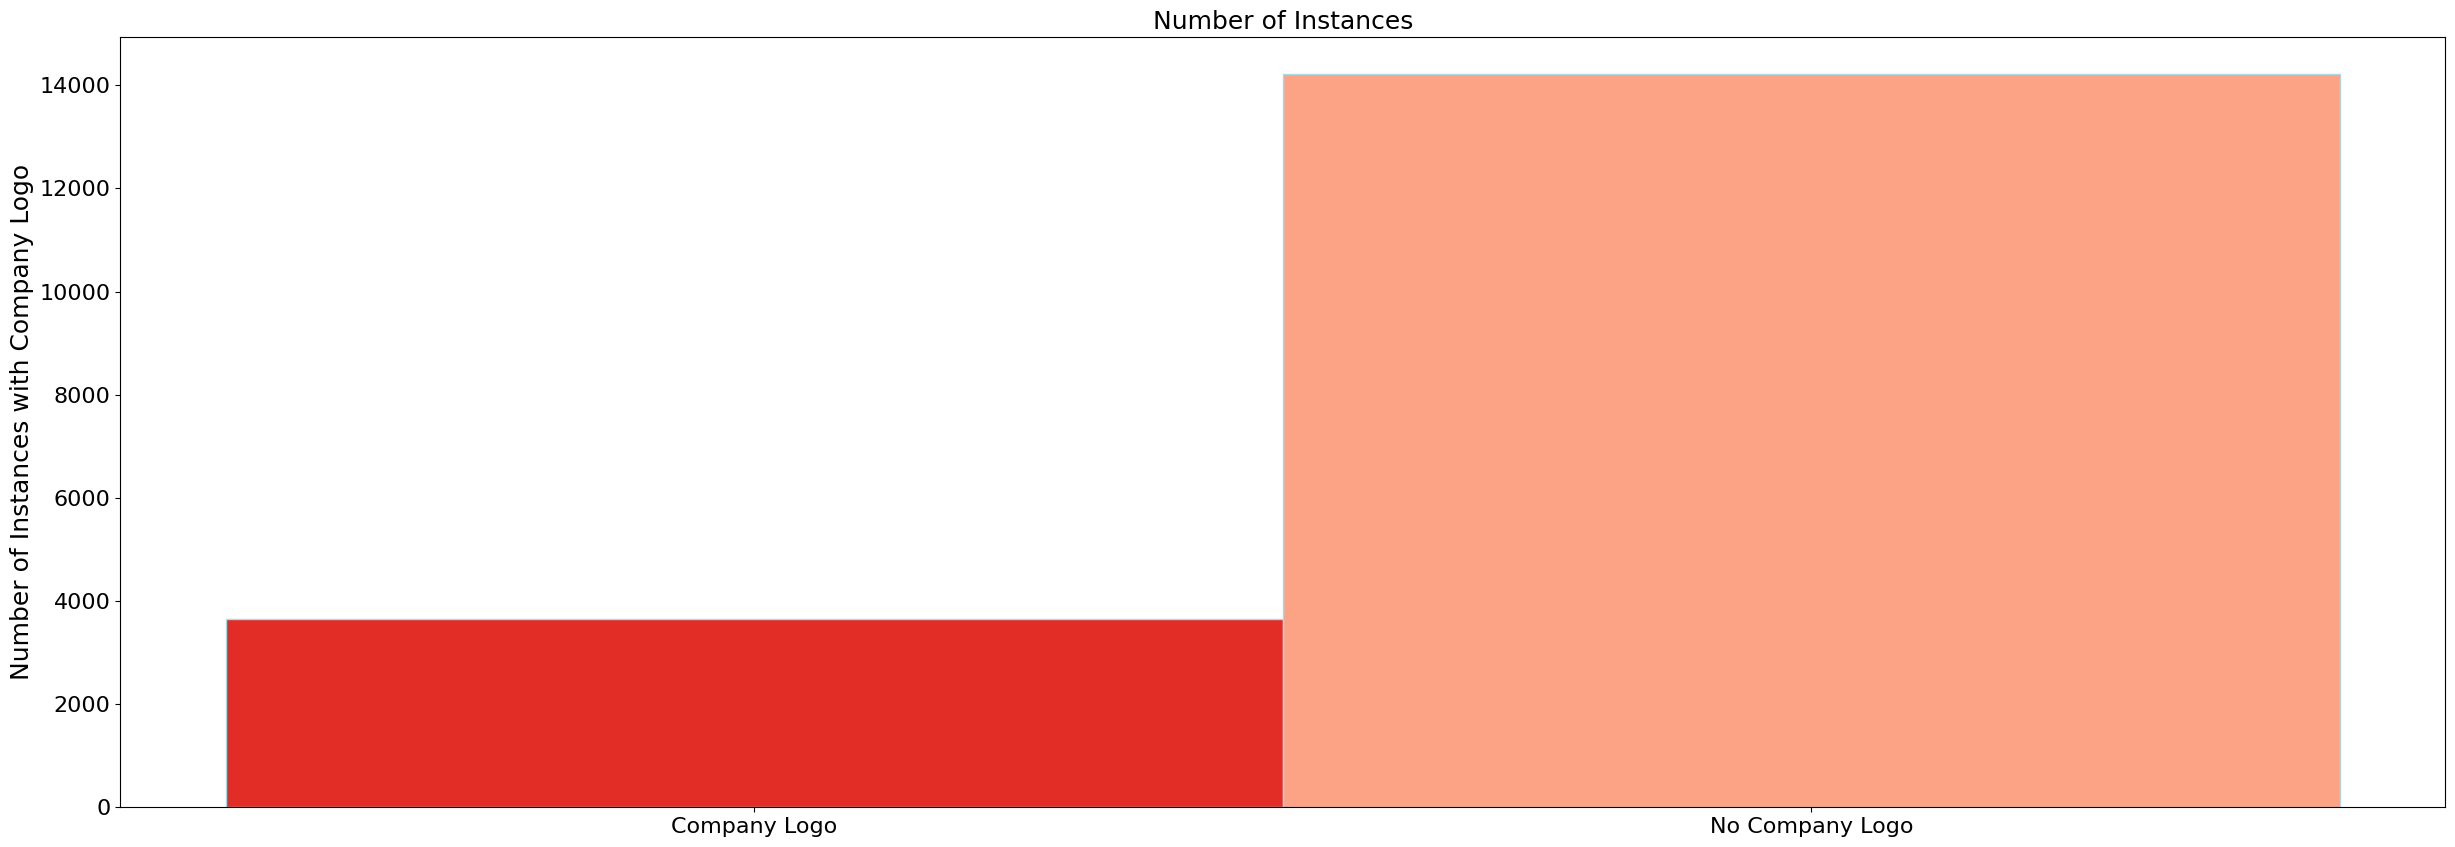

In [ ]:
#We now alanyse the abscence and presence of as, and its relation to the fraudulent class (by color) and the count in the dataset of each instance
has_logo=pd.DataFrame()

#Take only instances that have a company logo value (0 or 1) and a fraudulent value(0 or 1)
filtered_logo=full_data.dropna(subset=["fraudulent", "has_company_logo"])

has_logo["fraudulent"]=filtered_logo["fraudulent"]
has_logo["has_company_logo"]=filtered_logo["has_company_logo"]

#Count logos, colour and plot
logo_counts= has_logo.groupby('has_company_logo').size().reset_index()
total_fraudulent_instances = has_logo['fraudulent'].sum()
frauds_logo = has_logo.groupby('has_company_logo')["fraudulent"].agg(fraudulent=lambda x: sum(x)/total_fraudulent_instances if total_fraudulent_instances != 0 else 0).reset_index()
logo_counts=logo_counts.merge(frauds_logo)
logo_counts.rename(columns={0: 'count'}, inplace=True)
print(logo_counts)
plt.figure(figsize=(30, 10))
plt.bar(logo_counts.index, logo_counts["count"], width=1, align='center', edgecolor="lightblue", color=cmap(logo_counts["fraudulent"]))
plt.xticks(logo_counts.index, ["Company Logo", "No Company Logo"], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Number of Instances with Company Logo',  fontsize=18)
plt.title('Number of Instances',  fontsize=18)
plt.show()

The last plot in our data analysis explores the logo of the companies and is, like before, coloured according to the amount of the fraudulent instances in the category. We can see that about 70% of the fraudulent data does not have a logo. Additionally, overall, there are more companies with a logo than without. This heavily indicatet that the absence of a logo can imply that the job posting is fake and we find this feature useful for the training of our models.


In total, our dataset is quite imbalanced and includes some long texts which could be difficult to capture for models. The most important features are the presence of a logo, the degree and experience requirements and the country that the element comes from. In the following sections we will train and test the models on this dataset.

# 2.0 Tokenization

## 2.1 TFIDF

For the purely textual columns (Description, Company Profile, Requirements, Benefits) we apply tf-idf separately. We use english stopwords and set the level of maximal features to 5000 in our Vectorizer. Applying tf-idf to our textual columns helps in focusing on more important and telling words and helps the model to ignore less telling words in the texts. Since we select the datasets in a stratified way, that is we want the class imbalance remains and the proportion of the classes are the same. Since there are less documents of the fraudulent class in total per column, the elements that tf-idf deems important are the ones that are most telling about the fraudulent class which further assists our models in learning to distinguish between fraudulent and non-fraudulent.


We chose not to clean the text (stemmer /lemmer) since we expect fraudulent posts to perhaps have some spelling mistakes or exaggerating words. Also, we assume there may be different punctuation patterns between the classes and want to capture as much information as possible

In [ ]:
X = df[text_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['fraudulent'])

# Initializing a TF-IDF vectorizer with specified parameters
tfidf_vect = TfidfVectorizer(stop_words='english', max_features=5000)

# Applying TF-IDF to each text column separately and combining features with ColumnTransformer
# This prepares the text data for numerical analysis by converting it into TF-IDF vectors
preprocessor = ColumnTransformer(
    transformers=[
        ('desc_tfidf', tfidf_vect, 'description'), # TF-IDF for 'description' column
        ('comp_prof_tfidf', tfidf_vect, 'company_profile'), # TF-IDF for 'company_profile' column
        ('reqs_tfidf', tfidf_vect, 'requirements'), # TF-IDF for 'requirements' column
        ('benefits_tfidf', tfidf_vect, 'benefits') # TF-IDF for 'benefits' column
    ],
    remainder='drop'
)

# 3.0 Model Set Up for SKlearn Models

In sklearn’s train/test splitting, we chose to stratify on target variables during the train/test split. This ensures that the proportion of each target class is the same in the train and test sets. Otherwise, we may risk seeing a different percentage of fraudulent listings during testing, which can throw off our model.

When using sklearn models, we ensured to use macro-averaged metrics. Otherwise, we can always predict the majority class and get very high accuracy.

We also made sure to focus on macro metrics in our performance analysis. ‘Macro’ value for theprecision_recall_fscore_support param indicated to give equal (50/50) weights to each of the 2 target classes.


In [ ]:
def build_pipeline(classifier, classifier_name):
    """Define a pipeline with a preprocessor, SMOTE for balancing, and the classifier"""
    return ImbPipeline(steps=[
        ('preprocessor', preprocessor), # Preprocessing step using the preprocessor defined earlier
        ('classifier', classifier) # Classifier to be trained
    ])

# Dictionary containing different classifiers to be evaluated
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
     "Multinomial Naive Bayes": MultinomialNB(),
}

results_df = pd.DataFrame(columns=["Classifier", "Accuracy", "Macro Precision", "Macro Recall", "Macro F1", "ROC-AUC"])

for name, classifier in classifiers.items():
    print(f"Training {name}...")
    pipeline = build_pipeline(classifier, name)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(classifier, "predict_proba") else None

    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"{name} - Confusion Matrix:")
    print(conf_matrix)
    print("-----\n")

    print(f"\n{name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f"Macro-Averaged Precision: {precision}")
    print(f"Macro-Averaged Recall: {recall}")
    print(f"Macro-Averaged F1 Score: {f1}")

    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"{name} - ROC-AUC Score: {roc_auc}")
    print("-----\n")

    results_row = pd.DataFrame({
        "Classifier": [name],
        "Accuracy": [accuracy_score(y_test, y_pred)],
        "Macro Precision": [precision],
        "Macro Recall": [recall],
        "Macro F1": [f1],
        "ROC-AUC": [roc_auc] if y_pred_proba is not None else "N/A"
    })

    results_df = pd.concat([results_df, results_row], ignore_index=True)

    print(f"\n{name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))
    if y_pred_proba is not None:
        print(f"{name} - ROC-AUC Score: {roc_auc}")
    print("-----\n")


Training Logistic Regression...
Logistic Regression - Confusion Matrix:
[[3402    1]
 [  70  103]]
-----


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99      3403
     Class 1       0.99      0.60      0.74       173

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg       0.98      0.98      0.98      3576

Macro-Averaged Precision: 0.9851116625310175
Macro-Averaged Recall: 0.7975409320915411
Macro-Averaged F1 Score: 0.8666775188710207
Logistic Regression - ROC-AUC Score: 0.9912199198598991
-----


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99      3403
     Class 1       0.99      0.60      0.74       173

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted 

## 3.1 Performance Results


In [ ]:
results_df.sort_values('Macro F1', ascending=False)

,Classifier,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC-AUC
1,SVM,0.982942,0.991195,0.823699,0.888541,0.989192
0,Logistic Regression,0.980145,0.985112,0.797541,0.866678,0.991220
2,Gradient Boosting,0.979586,0.971533,0.799990,0.864795,0.946445
3,Multinomial Naive Bayes,0.974273,0.931333,0.767023,0.827840,0.972501


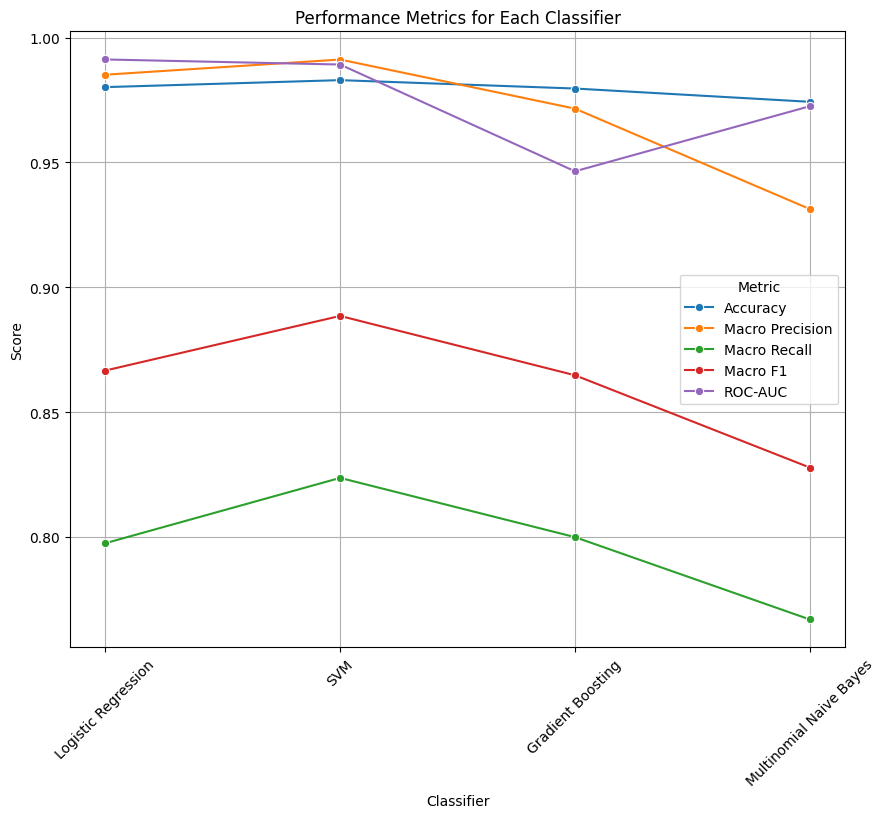

In [ ]:
melted_df = pd.melt(results_df, id_vars=["Classifier"], var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 8))
sns.lineplot(data=melted_df, x="Classifier", y="Score", hue="Metric", marker='o', sort=False)

plt.title('Performance Metrics for Each Classifier')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Metric')

plt.show()


The results suggest that SVM and Logistic Regression works better than Gradient Boosting and Multinomial Naive Bayes in terms of accuracy, precision, recall, and ROC-AUC score. SVM achieves the highest accuracy and ROC-AUC score, while Logistic Regression achieves the highest precision and recall. Gradient Boosting shows decent performance but has lower accuracy and ROC-AUC compared to the other classifiers. Multinomial Naive Bayes performs well but slightly lower than SVM and Logistic Regression in terms of accuracy and ROC-AUC score.
This result can be explained by several factors. For example, since the dataset likely contains class imbalance (more non-fraudulent job postings than fraudulent ones), the performance of classifiers can be influenced by how well they handle this imbalance. In this case, using techniques like SMOTE for oversampling of minority class samples can help improve the performance of classifiers like Logistic Regression and SVM, leading to better classification results. Also, SVM and Logistic Regression are generally considered to be powerful classifiers with relatively high capacity for learning complex patterns in the data. They have a flexible decision boundary and can capture intricate relationships between features and target classes. This could contribute to their superior performance compared to Gradient Boosting and Multinomial Naive Bayes.

# 4.0. Bert Model

#### *NOTE: We ran our model using on an external gpu, so we do not recommend running the code below in section X.0, but it is there for review. We include our analysis of the output in this section.

## 4.1 Training Description (for code, see below)

Due to the imbalance in the dataset, we hypothesized that we can safely drop the oversampled class (non-fraudulent listings) while maintaining a high accuracy. We didn't want to simply drop all rows until the class sizes are equal, since the undersampled class (fraudulent listings) is quite small (< 900 rows). Also, more data can still help the model learn about both classes, even in the case of imbalance.

To test how much we can drop, we trained the model with only a certain percentage of rows kept from the non-fraudulent class (percentages kept = [0.05, 0.1, 0.2, 0.4, 0.6, 0.75, 0.95, 1.0]).

Then, we plot the performance of a model trained on 5 epochs for each percentage value, to visually see when we experience a plateau in performance.

Reducing the dataset size can be an important task as we can lower the cost of training a model without sacrificing performance.

As before, we stratify the train/test split on the target column and consider macro-averaged metrics to account for the imbalance.

## 4.2 Test Results

### 4.2.1 Performance Analysis for differenet Percentages

To test how much we can drop, we trained the model with only a certain percentage of rows kept from the non-fraudulent class (portion kept = [0.05, 0.1, 0.2, 0.4, 0.6, 0.75, 0.95, 1.0]).

For example, 0.05 only keep 5% of the oversamples class. This is the most balanced case, with 866 fraudulent and 851 non-fraudulent.

In [ ]:
performance_data = {"0.05": {"Accuracy": 0.877906976744186, "Macro Precision": 0.877906976744186, "Macro Recall": 0.8779580797836376, "Macro F1": 0.8779028496095731, "confusion_matrix": [[150, 20], [22, 152]]}, "0.1": {"Accuracy": 0.896887159533074, "Macro Precision": 0.8934250107434465, "Macro Recall": 0.8724509687590054, "Macro F1": 0.8815415856781943, "confusion_matrix": [[323, 18], [35, 138]]}, "0.2": {"Accuracy": 0.9297423887587822, "Macro Precision": 0.9010542509388715, "Macro Recall": 0.8761766528311816, "Macro F1": 0.8878362286354721, "confusion_matrix": [[658, 23], [37, 136]]}, "0.4": {"Accuracy": 0.9609120521172638, "Macro Precision": 0.9601988760680809, "Macro Recall": 0.8392049264512405, "Macro F1": 0.8878339406457647, "confusion_matrix": [[1357, 5], [55, 118]]}, "0.6": {"Accuracy": 0.9733634311512416, "Macro Precision": 0.9324079158984819, "Macro Recall": 0.874450131062712, "Macro F1": 0.9009203260982465, "confusion_matrix": [[2025, 17], [42, 131]]}, "0.75": {"Accuracy": 0.975421863536317, "Macro Precision": 0.9348143311378605, "Macro Recall": 0.8467732623299349, "Macro F1": 0.8850720525652425, "confusion_matrix": [[2538, 15], [52, 121]]}, "0.95": {"Accuracy": 0.9844392248972401, "Macro Precision": 0.9493444827296411, "Macro Recall": 0.8823825470357173, "Macro F1": 0.9128465813436897, "confusion_matrix": [[3220, 13], [40, 133]]}, "1.0": {"Accuracy": 0.9868568232662193, "Macro Precision": 0.9497237128739174, "Macro Recall": 0.902567268934755, "Macro F1": 0.9246913331317002, "confusion_matrix": [[3389, 14], [33, 140]]}}


### *Note that all metrics are macro-weighted*

In [ ]:
pd.DataFrame(performance_data).T.sort_values('Macro F1', ascending=False)

,Accuracy,Macro Precision,Macro Recall,Macro F1,confusion_matrix
1.0,0.986857,0.949724,0.902567,0.924691,"[[3389, 14], [33, 140]]"
0.95,0.984439,0.949344,0.882383,0.912847,"[[3220, 13], [40, 133]]"
0.6,0.973363,0.932408,0.87445,0.90092,"[[2025, 17], [42, 131]]"
0.2,0.929742,0.901054,0.876177,0.887836,"[[658, 23], [37, 136]]"
0.4,0.960912,0.960199,0.839205,0.887834,"[[1357, 5], [55, 118]]"
0.75,0.975422,0.934814,0.846773,0.885072,"[[2538, 15], [52, 121]]"
0.1,0.896887,0.893425,0.872451,0.881542,"[[323, 18], [35, 138]]"
0.05,0.877907,0.877907,0.877958,0.877903,"[[150, 20], [22, 152]]"


As expected, we get the best results when we use all the data. This is because although all metrics are macro-weighted, more data still helps the model learn the difference between the 2 classes. We visualize the development of the metrics below.

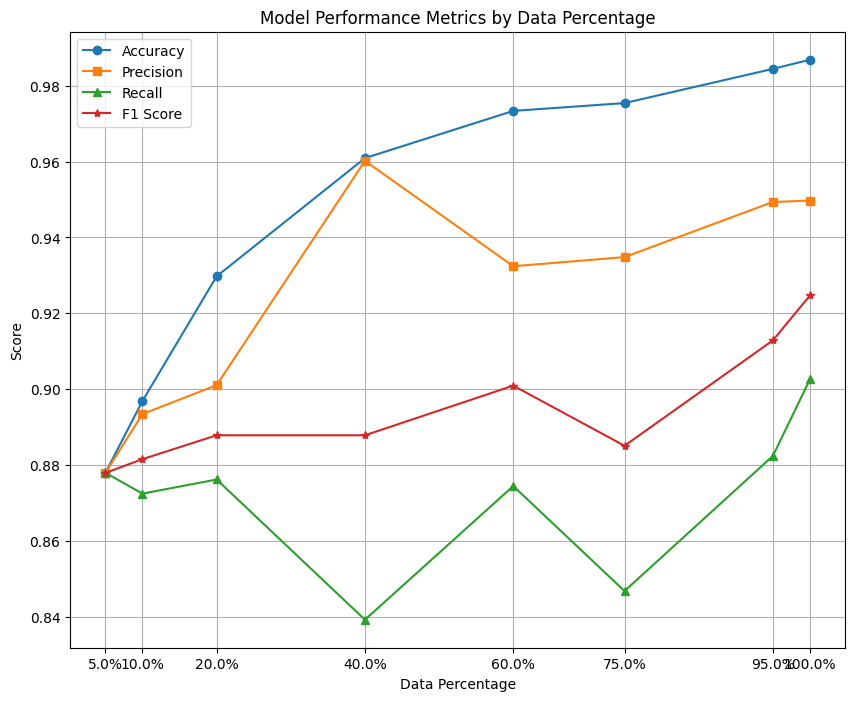

In [ ]:
# Extracting data for plotting
percentages = [float(k) for k in performance_data.keys()]
accuracy = [v["Accuracy"] for v in performance_data.values()]
precision = [v["Macro Precision"] for v in performance_data.values()]
recall = [v["Macro Recall"] for v in performance_data.values()]
f1_score = [v["Macro F1"] for v in performance_data.values()]

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(percentages, accuracy, label='Accuracy', marker='o')
plt.plot(percentages, precision, label='Precision', marker='s')
plt.plot(percentages, recall, label='Recall', marker='^')
plt.plot(percentages, f1_score, label='F1 Score', marker='*')

plt.title('Model Performance Metrics by Data Percentage')
plt.xlabel('Data Percentage')
plt.ylabel('Score')
plt.xticks(percentages, [f"{p*100}%" for p in percentages])
plt.legend()
plt.grid(True)
plt.show()


From the above plot, we can visually observe how macro-averaged performance metrics change as we keep more of the dataset. We focus on macro-averaged F1-score, as it is a harmonic mean of recall and precision and is more meaningful in imbalanced analysis. We observe that we get best results with the full dataset, but still objectively good results overall.

This tells us that there is a trade-off between the total amount of data that we have and the imbalanced dataset. If we remove too many datapoints, our dataset is too small, and the model we have is not expressive enough to learn the correct distribution. The peak at around 40% of data suggests, that the model is has less false positives (because precision is tp/tp+fp). However, the decrease in recall tells us that the model misses many of the fraudulent instances (recall = tp/tp+fn). which translates to false negatives

Overall reducing the amount of data to train on did not have a significant positive effect on the model. That is, trying to balance out the classes by removing datapoints doesnt help our performance. Reasons for that can be, that the models are not expressive enough and require more data to capture the fraudulent instances.

However, it can be argued that with a lower threshold, one can achieve good results on less data. For example, when keeping 60% of the oversampled class, we can still achievea result within ~ 2% of results with the full 100%.

### 4.2.2 Performance Analysis of Bert vs Sklearn models

In [ ]:
results_df_with_bert = results_df.copy()

bert_best_100 = performance_data["1.0"].copy()
bert_best_100["Classifier"] = 'bert 100%'

cols = [key for key in bert_best_100.keys() if key in results_df_with_bert.columns]

new_row_df = pd.DataFrame({key: [bert_best_100[key]] for key in cols})

results_df_with_bert = pd.concat([results_df_with_bert, new_row_df])
results_df_with_bert

,Classifier,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC-AUC
0,Logistic Regression,0.980145,0.985112,0.797541,0.866678,0.991220
1,SVM,0.982942,0.991195,0.823699,0.888541,0.989192
2,Gradient Boosting,0.979586,0.971533,0.799990,0.864795,0.946445
3,Multinomial Naive Bayes,0.974273,0.931333,0.767023,0.827840,0.972501
0,bert 100%,0.986857,0.949724,0.902567,0.924691,NaN


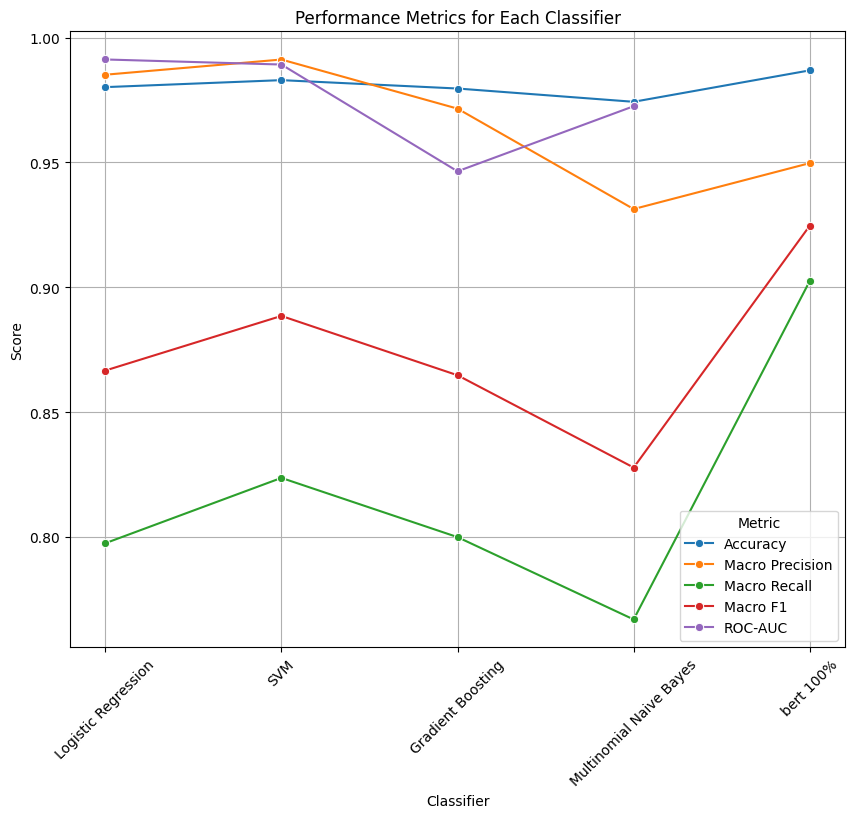

In [ ]:
melted_df = pd.melt(results_df_with_bert, id_vars=["Classifier"], var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 8))
sns.lineplot(data=melted_df, x="Classifier", y="Score", hue="Metric", marker='o', sort=False)

plt.title('Performance Metrics for Each Classifier')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Metric')

plt.show()


From the plot above, we observe that bert with 100% of the data performs best overall, especially when considereing Macro-averaged recall and f1. This can be attributed to the pre-trained nature of BERT that helps it handle metrics that are often lower in imbalanced datasets as this one.

However, we can also observe that it performs worse on percision. This can be again due to BERT's ability to be more robust and may indicate the the other models have overfitted to some points. Overall, the Logistic Regression and SVM are strong competitors for the BERT model in this case, and notable less expensive in terms of computation and training time.

### 4.3 Confusion Matrices for differnet Percentage Models

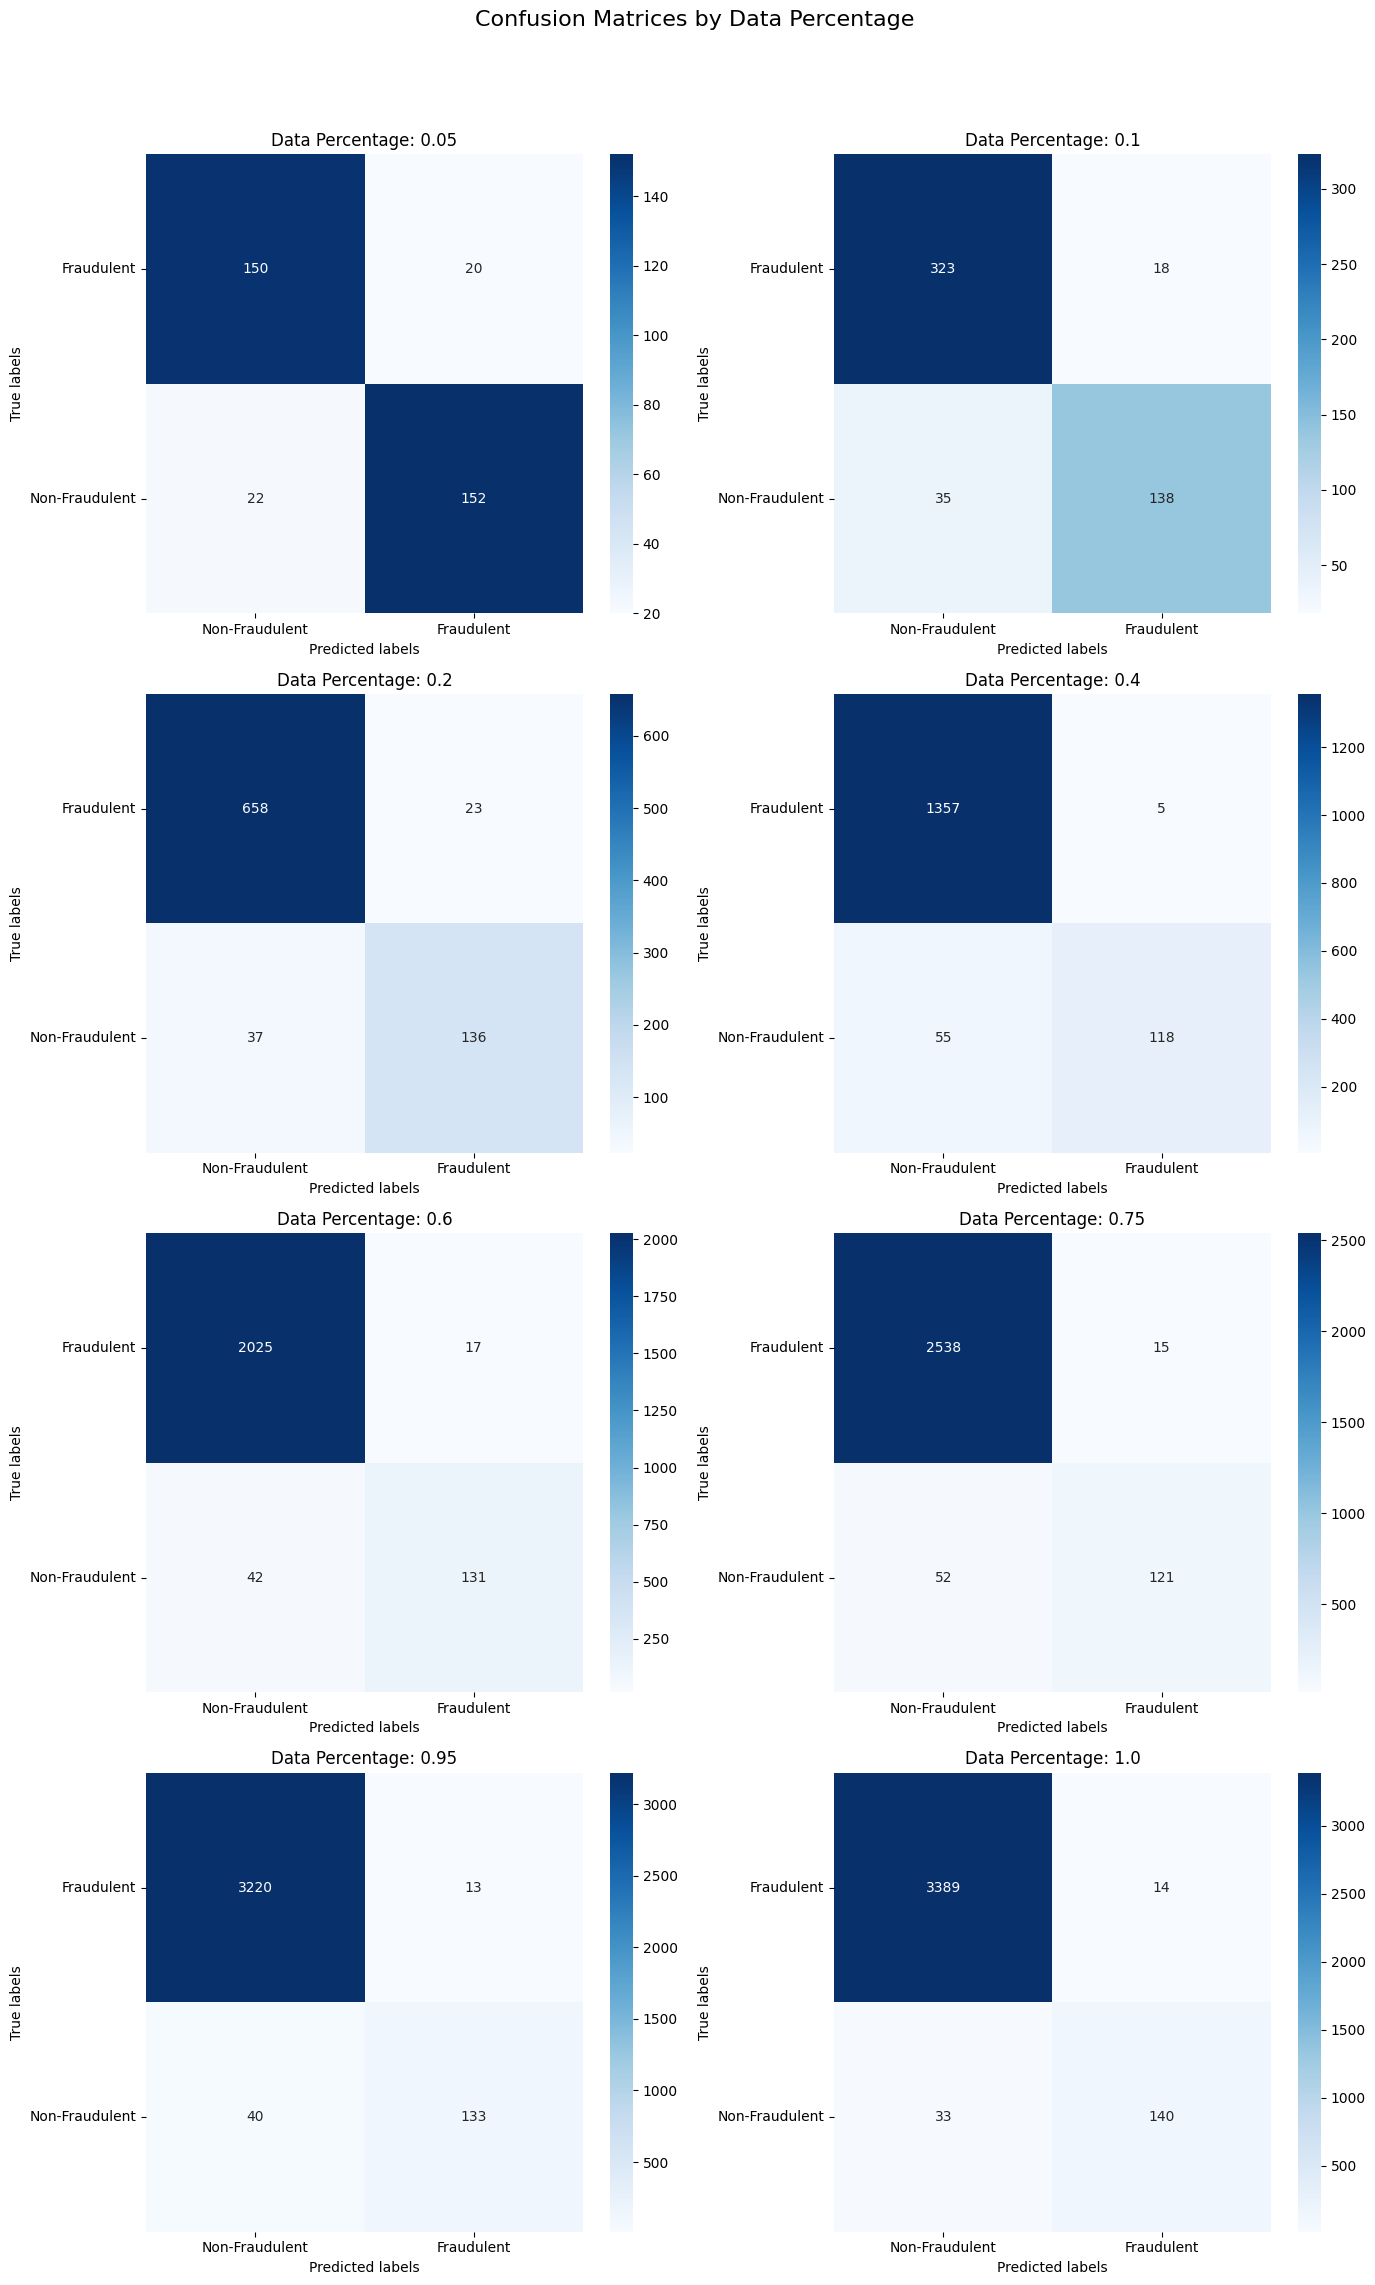

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 24))
fig.suptitle('Confusion Matrices by Data Percentage', fontsize=16)

axes = axes.flatten()

for i, (percentage, metrics) in enumerate(performance_data.items()):
    conf_matrix = metrics["confusion_matrix"]
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Data Percentage: {percentage}")
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')
    axes[i].set_xticklabels(['Non-Fraudulent', 'Fraudulent'])
    axes[i].set_yticklabels(['Fraudulent', 'Non-Fraudulent'], rotation=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


## 4.3 DO NOT RUN: Reserved for BERT code that is running on docker

### 4.3.1 Imports

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import json
print(torch.cuda.is_available())  # Should print True if CUDA is available

no_deprecation_warning=True
# Ensure CUDA is available and select the device
device = torch.device("cuda")

### 4.3.2 Custom Dataset Class

In [ ]:
class JobListingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
          'attention_mask': encoding['attention_mask'].squeeze(0),
          'labels': torch.tensor(labels, dtype=torch.long)
        }

In [ ]:
# Load the dataset
df_og = pd.read_csv('fake_job_postings.csv', on_bad_lines='skip').fillna("")
df_fraudulent = df_og[df_og['fraudulent'] == 1]
df_non_fraudulent = df_og[df_og['fraudulent'] == 0]

In [ ]:
#Print an Example datapoint
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
x_example=df_fraudulent.iloc[1][['description', 'company_profile', 'requirements', 'benefits']].agg(' '.join)
y_example=df_fraudulent.iloc[1]["fraudulent"]
example_datapoint=JobListingDataset([x_example], [y_example], tokenizer)


### 4.3.3 Train BERT model

Due to the imbalance in the dataset, we hypothesized that we can safely drop the oversampled class (non-fraudulent listings) while maintaining a high accuracy. We didn't want to simply drop all rows until the class sizes are equal, since the undersampled class (fraudulent listings) is quite small (< 900 rows). Also, more data can still help the model learn about both classes, even in the case of imbalance.

To test how much we can drop, we trained the model with only a certain percentage of rows kept from the non-fraudulent class (percentages kept = [0.05, 0.1, 0.2, 0.4, 0.6, 0.75, 0.95, 1.0]).

Then, we plot the performance of a model trained on 5 epochs for each percentage value, to visually see when we experience a plateau in performance.

Reducing the dataset size can be an important task as we can lower the cost of training a model without sacrificing performance.

As before, we stratify the train/test split on the target column and consider macro-averaged metrics to account for the imbalance.

In [ ]:
print(torch.cuda.is_available())  # Should print True if CUDA is available

no_deprecation_warning=True
# Ensure CUDA is available and select the device
device = torch.device("cuda")

False


In [ ]:
performance_dict = {}

percentages = [0.05, 0.1, 0.2, 0.4, 0.6, 0.75, 0.95, 1.0]

for p in percentages:
    print(f"========Training with {p*100}% of non-fraudulent data =======")

    df_non_fraudulent_sampled = df_non_fraudulent.sample(frac=p, random_state=42)
    df_balanced = pd.concat([df_fraudulent, df_non_fraudulent_sampled])
    df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"non fraudulent data size: {len(df_non_fraudulent_sampled.index)}")
    print(f"fraudulent data size: {len(df_fraudulent.index)}")

    # Keep class weights for correct loss weighting
    class_counts = df['fraudulent'].value_counts()
    class_weights = torch.tensor([1 / class_counts[0], 1 / class_counts[1]]).to(device)

    print(f"class weights: {class_counts}")

    df['combined_text'] = df[['description', 'company_profile', 'requirements', 'benefits', '']].agg(' '.join, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df['combined_text'], df['fraudulent'], test_size=0.2, stratify=df['fraudulent'], random_state=42)

    # Tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Prepare datasets
    train_dataset = JobListingDataset(X_train.tolist(), y_train.tolist(), tokenizer)
    test_dataset = JobListingDataset(X_test.tolist(), y_test.tolist(), tokenizer)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

    # Model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5, no_deprecation_warning=True)

    # Training loop
    num_epochs = 5
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        total_batches = 0
        for batch_idx, batch in enumerate(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            weighted_loss = loss * class_weights[batch['labels']]
            total_loss += weighted_loss.sum().item()  # Accumulate the sum of losses
            total_batches += 1
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(f'Epoch {epoch+1} finished, Avg Loss: {total_loss / len(train_loader)}')

    # Evaluation loop

    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():

        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=-1).tolist())
            true_labels.extend(batch['labels'].tolist())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions)

    performance_dict[p] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix.tolist()
    }
    print(f"Accuracy: {accuracy}")
    print(f"Macro Precision: {precision}")
    print(f"Macro Recall: {recall}")
    print(f"Macro F1 Score: {f1}")

    # Save the model and tokenizer
    model.save_pretrained('./bert_finetuned')
    tokenizer.save_pretrained('./bert_finetuned')

with open('performance_metrics.json', 'w') as f:
    json.dump(performance_dict, f)


# 5.0 DO NOT RUN - Generation of More Samples

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 27 18:23:37 2024

@author: nayou
"""

import requests
import json
import re
import pandas as pd
import csv

def get_ollama_response(prompt):
    """
    Send prompt to the local server to return the answer

    :param str prompt: prompt that is sent to the server
    :return: the answer to the prompt

    """

    url = "http://localhost:11434/api/generate/"
    data = {
        "model" : "llama2",
        "prompt": prompt,
        "max_tokens": 1000
    }

    # Make a POST request to the server
    response = requests.post(url, json=data)

    # Check if the request was successful
    if response.status_code == 200:
        # Process the response
        response_text = response.text

        # Convert each line to json
        response_lines = response_text.splitlines()
        response_json = [json.loads(line) for line in response_lines]

        response = ""
        for line in response_json:
            response += line["response"]
        return response
    else:
        print("Error:", response.status_code)



def get_prompt(i) :
    """
    Function that returns the prompt p

    :param str question: initial question
    :param str answer: answer to the initial question
    :param str p: which prompt
    :return: prompt to generate questions
    """
    prompts = {"p" : (f"You should generate one fake job post. You should respect the following format:"
        "The first column is called 'job_id'. It is set to {i}."

        "The second column is called 'title' which is a string representing the title of the job ad entry. It can not be empty. For example, 'Marketing Intern' or 'Head of Content (m/f)' or 'Intensive Case Management Worker (Bilingual Essential)'."

        "The third column is called 'location' which is in the format 'country, state, city' representing the geographical location of the job ad.It can be empty by setting this column 'null'. For example, 'US, CA, San Francisco' or 'DE, BE, Berlin'."

        "The forth column is called 'departement' which is a string representing the corporate department (e.g. sales). It can be empty by setting this column 'null'. For example, 'Marketing' or 'R&D' or 'Engagement' or 'Success'."

        "The fifth column is called 'salary_range' which is a string representing the indicative salary range (e.g. $50,000-$60,000). It can be empty by setting this column 'null'. For example, '20000-28000' or '100000-120000' or '50000-65000'."

        "The sixth column is called 'company_profile' which is a string text representing a brief company description. It can be empty by setting this column 'null'. If it is not empty, it should be around 92 words and at most 243 words."

        "The seventh column is called 'description' which is a string text representing the details description of the job ad. It can not be empty, it should have around 170 words, at least 35 words and no more than 390."

        "The eighth column is called 'requirements' which is a string text representing an enlisted requirements for the job opening. It can be empty by setting this column 'null'. If not empty, it should be around 78 words, but no more than 200."

        "The ninth column is called 'benefits' which is a string text representing an enlisted offered benefits by the employer. It can be empty by setting this column 'null'. If not empty, it should be around 30 words, but no more than 120."

        "The tenth column is called 'telecommuting'. It should be 1 if this position can be done by telecommuting, 0 otherwise. It can not be empty."

        "The eleventh column is called 'has_company_logo'. It should be 1 if the company's logo is present, 0 otherwise. It can not be empty."

        "The twelfth column is called 'has_questions'. It should be 1 if screening questions are present, 0 otherwise. It can not be empty."

        "The thirteenth column is called 'employment_type' which is a string representing the emplyement type. For example, 'Full-type' or 'Part-time' or 'Contract'. It can be empty by setting this column 'null'."

        "The fortheenth column is called 'required_experience' which is a string representing the required experience to apply for this job. For example, 'Executive' or 'Entry level' or 'Intern'. It can be empty by setting this column 'null'."

        "The fiftheenth column is called 'required_education' which is a string representing the required education to apply for this job. For example, 'Doctorate' or 'Master’s Degree' or 'Bachelor'. It can be empty by setting this column 'null'."

        "The sixteenth column is called 'industry' which is a string representing the industry which the company specializes in. For example, 'Automotive' or 'IT' or 'Health care' or 'Real estate'. It can be empty by setting this column 'null'."

        "The seventeenth column is called 'function' which is a string representing the position of the job. For example, 'Consulting' or 'Engineering' or 'Research' or 'Sales'. It can be empty by setting this column 'null'."

        "The eighteenth column is called 'fraudulent' which is always set to 1."

        "I want you to print the all 18 answers separated by a semicolon."

        "Be creative.")}
    return prompts['p']


def add_data() :
    with open("fake_job_posts.txt", "r") as file:
        data = file.read()

    # Define regular expressions for extracting different features
    job_regex = re.compile(r"Job ID: (\d+)\nTitle: (.*?)\nLocation: (.*?)\nDepartment: (.*?)\nSalary Range: (.*?)\nCompany Profile: (.*?)\nDescription: (.*?)\nRequirements: (.*?)\nBenefits: (.*?)\nTelecommuting: (.*?)\nHas Company Logo: (.*?)\nHas Questions: (.*?)\nEmployment Type: (.*?)\nRequired Experience: (.*?)\nRequired Education: (.*?)\nIndustry: (.*?)\nFunction: (.*?)\nFraudulent: (\d+)", re.DOTALL)

    # Find all job listings
    job_listings = job_regex.findall(data)

    # Write the extracted data to a CSV file
    with open("generated_data.csv", "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)

        # Write header
        writer.writerow(["job_id","title","location","department","salary_range","company_profile","description","requirements","benefits","telecommuting","has_company_logo","has_questions","employment_type","required_experience","required_education","industry","function","fraudulent"])

        # Write data rows
        writer.writerows(job_listings)

    print("CSV file created successfully!")


In [ ]:
# -*- coding: utf-8 -*-
"""
main function which create generated questions
"""

import pandas as pd
from create_data import get_prompt, get_ollama_response


def main():
    # Get data

    # list_q = generate_questions(df_questions, df_answers)
    # df = pd.DataFrame(list_q)
    # df.to_csv('generatedQ_v3.csv', encoding='utf-8', index=False)

    # print(df[df['fraudulent'] == 1].head(1))
    # all_result = []

    s = "We are seeking an Intensive Case Management Worker to join our team in Toronto, Ontario. The successful candidate will be responsible for providing intensive case management services to individuals with mental health conditions, focusing on their recovery and well-being. This is a full-time position, 35 hours per week."
    print(len(s.split(' ')))

    with open('fake_job_posts.txt', 'w') as f:
        for i in range(1):
            prompt = get_prompt(i)
            print(prompt)
            result = get_ollama_response(prompt)
            print(f"{i} is done.")
            f.write(result)
            print(i)

    print(result)


if __name__ == "__main__":
    main()
